In [1]:
# For inline plotting
%matplotlib inline

# For auto reloading
%load_ext autoreload
%autoreload 2


In [2]:
import math
import pickle
from pathlib import Path

import numpy as np

from mab import GleapAgent, GleapEpsilonGreedyAgent, UcbAgent, UniformlyRandomAgent, HEpsilonGreedyAgent
import simulation_config


# Load all the simulation objects
# date = "20210820_211854"
# date = "20220126_162141"
# date = "20220126_192833"
# date = "20220126_193505"
# date = "20220126_224346"
# date = "20220127_145355"
# date = "20220127_215653"
# date = "20220219_201503"
date = "20220713_161313"
simulation_list = []
pathlist = Path("./simulations_data/comparison/{:s}".format(date)).glob('*.pkl')
for path in pathlist:
    with open(path, "rb") as f:
        simulation_list.append(pickle.load(f))
print("# of simulations: {:d}".format(len(simulation_list)))
print("# of repetitions: {:d}".format(simulation_list[0].aggregated_compound_reward_2darray.shape[0]))


# Sort the simulation list
def value_func(simulation_index):
    simulation = simulation_list[simulation_index]
    agent = simulation.agent
    
    # Assume that the parameters are smaller than max_param
    max_param = 10000.0
    value = 0.0
    if isinstance(agent, GleapAgent):
        # Print some hyperparameter settings
        print("V = {:.2f}".format(agent.v))
        print("beta = {:.2f}".format(agent.beta))
        
        # Normal G-LEAP
        if agent.v < math.inf:
            value += 1 * max_param
            value += agent.gamma
            value += agent.h
        
            agent.name = simulation_config.ALG_NAME
            agent.chinese_name = simulation_config.ALG_NAME
        # G-LEAP without control (UCB)
        else:
            value += 3 * max_param
            
            agent.name = "UCB"
            agent.chinese_name = "UCB"
    elif isinstance(agent, GleapEpsilonGreedyAgent) or isinstance(agent, HEpsilonGreedyAgent):
        value += 4 * max_param
        value += agent.epsilon
        
        agent.name = r"$\epsilon$-Greedy"
        agent.chinese_name = r"$\epsilon$-Greedy"
    elif isinstance(agent, UcbAgent):
        value += 3 * max_param
        value += agent.gamma
        
        agent.name = { "english": "UCB", "chinese": "UCB" }
    elif isinstance(agent, UniformlyRandomAgent):
        value += 2 * max_param
        
        agent.name = "Random"
        agent.chinese_name = "均匀随机"
    
    return value


# Display the arm selection fraction table for each agent in the sorted order
simulation_index_list = [ i for i in range(len(simulation_list)) ]
sorted_simulation_index_list = sorted(simulation_index_list, key=lambda i: value_func(i))
print("\n---=== Arm Selection Fraction Table ===---")
num_arm = simulation_list[0].env.num_arm
print("             Agent", end="")
for arm_index in range(num_arm):
    print(",  Arm #{:1d}".format(arm_index), end="")
print(",  Most Selected")
for simulation_index in sorted_simulation_index_list:
    simulation = simulation_list[simulation_index]
    print("{:>18s}".format(simulation.agent.name), end="")
    arm_selection_fraction_array = np.sum(simulation.arm_selection_count_2darray, axis=0) / (simulation.num_repetition * simulation.num_round)
    for arm_index, selection_fraction in enumerate(arm_selection_fraction_array):
        print(", {:>6.1f}%".format(selection_fraction * 100), end="")
    print(",  ", end="")
    print(sorted([ pair[0] for pair in sorted(enumerate(arm_selection_fraction_array), key=lambda x: x[1], reverse=True)][:simulation.env.num_selection]))


# of simulations: 4
# of repetitions: 100
V = inf
beta = 0.70
V = 100000.00
beta = 0.70

---=== Arm Selection Fraction Table ===---
             Agent,  Arm #0,  Arm #1,  Arm #2,  Arm #3,  Arm #4,  Arm #5,  Arm #6,  Arm #7,  Arm #8,  Arm #9,  Most Selected
            G-LEAP,   15.3%,   12.0%,    0.7%,   24.0%,   16.9%,   34.6%,   35.1%,   61.7%,    1.0%,   98.7%,  [6, 7, 9]
            Random,   30.0%,   30.0%,   30.0%,   30.0%,   30.0%,   30.0%,   30.0%,   30.0%,   30.0%,   29.9%,  [2, 5, 7]
               UCB,    6.7%,    3.3%,    0.5%,   28.6%,   54.0%,    9.9%,   10.1%,   89.1%,    3.0%,   94.8%,  [4, 7, 9]
 $\epsilon$-Greedy,    6.1%,    6.1%,    6.0%,    6.6%,   85.2%,    6.2%,    5.9%,   85.9%,    6.1%,   85.9%,  [4, 7, 9]


In [3]:
import subprocess
from pathlib import Path
import shutil

import numpy as np
import matplotlib
print("matplotlib.__version__:", matplotlib.__version__)
print('Default backend: ' + matplotlib.get_backend())
# matplotlib.use("module://mplcairo.base")
print('Backend is now ' + matplotlib.get_backend())
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
# matplotlib.rcParams['mathtext.fontset'] = 'cm'
# matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


def calculate_metrics(simulation_index):
    simulation = simulation_list[simulation_index]
    
    # For reward
    time_averaged_compound_reward_array = np.mean(simulation.time_averaged_compound_reward_2darray, axis=0)
    aggregated_compound_reward_array = np.mean(simulation.aggregated_compound_reward_2darray, axis=0)
    
    # For regret
    time_averaged_regret_array = np.mean(simulation.time_averaged_regret_2darray, axis=0)
    cumulative_regret_array = np.mean(simulation.cumulative_regret_2darray, axis=0)
    
    # For time-averaged total prediction accuracy
    time_averaged_total_prediction_accuracy_array = np.mean(simulation.time_averaged_total_prediction_accuracy_2darray, axis=0)
    
    # For queue length
    q_array = np.mean(simulation.q_2darray, axis=0)
    
    # For user satisfaction
    time_averaged_user_satisfaction_array = np.mean(simulation.time_averaged_user_satisfaction_2darray, axis=0)
    
    # For time-averaged total prediction latency
    time_averaged_total_prediction_latency_array = np.mean(simulation.time_averaged_total_prediction_latency_2darray, axis=0)
    
    # For time-averaged energy consumption
    time_averaged_energy_consumption_array = np.mean(simulation.time_averaged_energy_consumption_2darray, axis=0)
    
    return {\
            "time_averaged_compound_reward_array": time_averaged_compound_reward_array,\
            "aggregated_compound_reward_array": aggregated_compound_reward_array,\
            "time_averaged_regret_array": time_averaged_regret_array,\
            "cumulative_regret_array": cumulative_regret_array,\
            "time_averaged_total_prediction_accuracy_array": time_averaged_total_prediction_accuracy_array,\
            "q_array": q_array,\
            "time_averaged_user_satisfaction_array": time_averaged_user_satisfaction_array,\
            "time_averaged_total_prediction_latency_array": time_averaged_total_prediction_latency_array,\
            "time_averaged_energy_consumption_array": time_averaged_energy_consumption_array\
           }


def plot():
    # mkdir
    figure_path = Path("./simulations_data/comparison/{:s}/figures".format(date))
    figure_path.mkdir(parents=True, exist_ok=True)
    shutil.rmtree(figure_path)
    figure_path.mkdir(parents=True, exist_ok=True)
    chinese_figure_path = Path("./simulations_data/comparison/{:s}/chinese_figures".format(date))
    chinese_figure_path.mkdir(parents=True, exist_ok=True)
    shutil.rmtree(chinese_figure_path)
    chinese_figure_path.mkdir(parents=True, exist_ok=True)
    
    
    color_list = [ '#009E73', '#E69F00', '#0072B2', '#D55E00' ]
    marker_list = [ 's', 'o', 'v', '^' ]
    num_round = simulation_list[0].num_round
    MARK_EVERY = (num_round // 10, num_round // 5)
    MARKER_SIZE = 25.0
    MARKER_SIZE_CHINESE = 14.0
    LINE_WIDTH = 6.0
    LINE_WIDTH_CHINESE = 3.0
    FONT_SIZE = 36.0
    FONT_SIZE_CHINESE = 32.0
    FONT_SIZE_TICK = 32.0
    FONT_SIZE_TICK_CHINESE = 26.0
    FONT_SIZE_TICK_OFFSET_TEXT = 28.0
    FONT_SIZE_TICK_OFFSET_TEXT_CHINESE = 24.0
    FIG_SIZE = (16,9)
#     cm = 1/2.54  # centimeters in inches
#     FIG_SIZE_CHINESE = (12*cm, 9*cm)
    FIG_SIZE_CHINESE = (8,6)
    DPI = 120
    DPI_CHINESE = 300
    GRID = True
    GRID_LINE_STYLE = (0,(8,4))
    FONT_WEIGHT = "normal"
    CHINESE_FONT_WEIGHT = "normal"
    if CHINESE_FONT_WEIGHT == "bold":
        CHINESE_FP = fm.FontProperties(fname='./font/source_han_serif_cn_bold.ttf', math_fontfamily="stix")
    else:
        CHINESE_FP = fm.FontProperties(fname='./font/source_han_serif_cn_regular.ttf', math_fontfamily="stix")
#     CHINESE_FP = fm.FontProperties(fname='./font/noto_serif_sc_regular.otf', math_fontfamily="stix")
#     CHINESE_FP = fm.FontProperties(fname='./font/geetype_songti.ttf', math_fontfamily="stix")
#     CHINESE_FP = fm.FontProperties(fname='./font/fangzheng_shusong.ttf', math_fontfamily="stix")
#     CHINESE_FP = fm.FontProperties(fname='./font/fangzheng_shusong.ttf', math_fontfamily="dejavuserif")
    NOTO_FP = fm.FontProperties(fname='./font/noto_serif_regular.ttf', math_fontfamily="stix")
    SAVE_CHINESE_PDF = True
    
    time_averaged_compound_reward_array_list = []
    aggregated_compound_reward_array_list = []
    time_averaged_regret_array_list = []
    cumulative_regret_array_list = []
    time_averaged_total_prediction_accuracy_array_list = []
    q_array_list = []
    time_averaged_user_satisfaction_array_list = []
    time_averaged_total_prediction_latency_array_list = []
    time_averaged_energy_consumption_array_list = []
    for i in sorted_simulation_index_list:
        metrics = calculate_metrics(i)
        
        time_averaged_compound_reward_array_list.append(metrics["time_averaged_compound_reward_array"])
        aggregated_compound_reward_array_list.append(metrics["aggregated_compound_reward_array"])
        time_averaged_regret_array_list.append(metrics["time_averaged_regret_array"])
        cumulative_regret_array_list.append(metrics["cumulative_regret_array"])
        time_averaged_total_prediction_accuracy_array_list.append(metrics["time_averaged_total_prediction_accuracy_array"])
        q_array_list.append(metrics["q_array"])
        time_averaged_user_satisfaction_array_list.append(metrics["time_averaged_user_satisfaction_array"])
        time_averaged_total_prediction_latency_array_list.append(metrics["time_averaged_total_prediction_latency_array"])
        time_averaged_energy_consumption_array_list.append(metrics["time_averaged_energy_consumption_array"])
    
    
    # Display the converged average reward, average user satisfaction, and average response latency
    print("               Agent, Average Reward, Average User Satisfaction, Average Response Latency")
    for index, simulation_index in enumerate(sorted_simulation_index_list):
        simulation = simulation_list[simulation_index]
        converged_time_averaged_compound_reward = time_averaged_compound_reward_array_list[index][-1]
        converged_time_averaged_user_satisfaction = time_averaged_user_satisfaction_array_list[index][-1]
        converged_time_averaged_total_prediction_latency = time_averaged_total_prediction_latency_array_list[index][-1]
        print("{:>20s}, {:>14.4f}, {:>25.4f}, {:>24.4f}".format(simulation.agent.name, converged_time_averaged_compound_reward, converged_time_averaged_user_satisfaction, converged_time_averaged_total_prediction_latency))
    
    
    ##########################################################################################
    # Beginning for time-averaged compound reward
    
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
#     ax.set_yticks([ -1200, -300, 600 ])
    ax.set_ylim(0.2, 0.5)
    plt.locator_params(axis='x', nbins=5)
    for index, time_averaged_compound_reward_array in enumerate(time_averaged_compound_reward_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_compound_reward_array.shape[0] + 1), time_averaged_compound_reward_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE, linewidth=LINE_WIDTH, antialiased=False)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
#     ax.xaxis.get_offset_text().set(visible=False)
#     ax.yaxis.get_offset_text().set(visible=False)
    ax.set_xlabel(r'Round', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Average Reward', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    # Save the figure
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_time_averaged_compound_reward.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_time_averaged_compound_reward.png'.format(date), format='png', bbox_inches='tight')
    
    # For the Chinese version
    fig, ax = plt.subplots(figsize=FIG_SIZE_CHINESE, dpi=DPI_CHINESE)
    ax.set_ylim(0.1, 0.5)
    plt.locator_params(axis='x', nbins=5)
    for index, time_averaged_compound_reward_array in enumerate(time_averaged_compound_reward_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_compound_reward_array.shape[0] + 1), time_averaged_compound_reward_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.chinese_name, markersize=MARKER_SIZE_CHINESE, linewidth=LINE_WIDTH_CHINESE, antialiased=False)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
#     plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=NOTO_FP)
#     plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=NOTO_FP)
#     plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=NOTO_FP)
#     plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=NOTO_FP)
#     ax.xaxis.get_offset_text().set(visible=False)
#     ax.yaxis.get_offset_text().set(visible=False)
    ax.set_xlabel(r'轮次', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_ylabel(r'平均奖励', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    # Save the figure
    if SAVE_CHINESE_PDF: fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_compound_reward.pdf'.format(date), format='pdf', bbox_inches='tight')
#     subprocess.run(["pdf2ps", './simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_compound_reward.pdf'.format(date), './simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_compound_reward.ps'.format(date)])
#     subprocess.run(["ps2pdf", "-dPDFSETTINGS=/prepress", './simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_compound_reward.ps'.format(date), './simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_compound_reward_optimized.pdf'.format(date)])
#     fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_compound_reward.eps'.format(date), format='eps', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_compound_reward.png'.format(date), format='png', bbox_inches='tight')
    
    # Ending for time-averaged compound reward
    ##########################################################################################
    
    
    ##########################################################################################
    # Beginning for cumulative reward
    
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
#     ax.set_yticks([ -1200, -300, 600 ])
    plt.locator_params(axis='x', nbins=5)
    lines = []
    labels = []
    for index, aggregated_compound_reward_array in enumerate(aggregated_compound_reward_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        l = ax.plot(range(1, aggregated_compound_reward_array.shape[0] + 1), aggregated_compound_reward_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
#         print(type(l[0]))
        print(l[0])
        lines.append(l[0])
        labels.append(agent.name)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    ax.set_xlabel(r'Round', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Cumulative Reward', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    # Save the figure
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_cumulative_reward.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_cumulative_reward.png'.format(date), format='png', bbox_inches='tight')
    # For legends
    import pylab
    fig_legend = pylab.figure(figsize=FIG_SIZE, dpi=DPI)
#     print(len(lines))
#     for l in lines:
#         print(l)
    handles, labels = ax.get_legend_handles_labels()
#     print(type(handles[0])) # <class 'matplotlib.lines.Line2D'>
#     print(type(labels)) # <class 'list'>
#     print(type(labels[0])) # <class 'str'>
    # sort both labels and handles by labels
#     labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    fig_legend.legend(lines, labels, ncol=5, shadow=True, loc='center', prop=fm.FontProperties(size=32.0, style="normal"))
    fig_legend.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_legend.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig_legend.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_legend.png'.format(date), format='png', bbox_inches='tight')
    
    # For the Chinese version
    fig, ax = plt.subplots(figsize=FIG_SIZE_CHINESE, dpi=DPI_CHINESE)
#     ax.set_yticks([ -1200, -300, 600 ])
    plt.locator_params(axis='x', nbins=5)
    lines = []
    labels = []
    for index, aggregated_compound_reward_array in enumerate(aggregated_compound_reward_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        l = ax.plot(range(1, aggregated_compound_reward_array.shape[0] + 1), aggregated_compound_reward_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.chinese_name, markersize=MARKER_SIZE_CHINESE, linewidth=LINE_WIDTH_CHINESE)
#         print(type(l[0]))
        print(l[0])
        lines.append(l[0])
        labels.append(agent.name)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_xlabel(r'轮次', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_ylabel(r'累积奖励', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    # Save the figure
    if SAVE_CHINESE_PDF: fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_cumulative_reward.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_cumulative_reward.png'.format(date), format='png', bbox_inches='tight')
    # For legends
    import pylab
    fig_legend = pylab.figure(figsize=FIG_SIZE_CHINESE, dpi=DPI_CHINESE)
#     print(len(lines))
#     for l in lines:
#         print(l)
    handles, labels = ax.get_legend_handles_labels()
#     print(type(handles[0])) # <class 'matplotlib.lines.Line2D'>
#     print(type(labels)) # <class 'list'>
#     print(type(labels[0])) # <class 'str'>
    # sort both labels and handles by labels
#     labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    if CHINESE_FONT_WEIGHT == "bold":
        fig_legend.legend(lines, labels, ncol=5, shadow=True, loc='center', prop=fm.FontProperties(size=32.0, style="normal", weight=CHINESE_FONT_WEIGHT, fname='./font/source_han_serif_cn_bold.ttf', math_fontfamily="stix"))
    else:
        fig_legend.legend(lines, labels, ncol=5, shadow=True, loc='center', prop=fm.FontProperties(size=32.0, style="normal", weight=CHINESE_FONT_WEIGHT, fname='./font/source_han_serif_cn_regular.ttf', math_fontfamily="stix"))
    if SAVE_CHINESE_PDF: fig_legend.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_legend.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig_legend.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_legend.png'.format(date), format='png', bbox_inches='tight')
    
    # Ending for cumulative reward
    ##########################################################################################
    
    
    ##########################################################################################
    # Beginning for queue length
    
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
#     ax.set_yticks([ 0, 10000, 20000, 30000 ])
#     ax.set_yticklabels(['0.0', '1.0', '2.0'], fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.locator_params(axis='x', nbins=5)
    for index, q_array in enumerate(q_array_list):
        if q_array is None:
            continue
        
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(q_array.shape[0]), q_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    #########################
    # Beginning for inset
    axins = ax.inset_axes([ 0.02, 0.50, 0.42, 0.47 ])
    for index, q_array in enumerate(q_array_list):
        axins.plot(range(5000 + 1), q_array[0:5000 + 1], marker_list[index], markevery=(500, 1000), linestyle='-', color=color_list[index], markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
    x1, x2, y1, y2 = 0, 5000, 0, 5000
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticks([])
    axins.set_yticks([])
    ax.indicate_inset_zoom(axins, edgecolor="#000000", linewidth=2, linestyle="-.", alpha=0.8)
    # Ending for inset
    #########################
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    ax.set_xlabel(r'Round', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Queue Length', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    # Save the figure
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_queue_length.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_queue_length.png'.format(date), format='png', bbox_inches='tight')
    
    # For the Chinese version
    fig, ax = plt.subplots(figsize=FIG_SIZE_CHINESE, dpi=DPI_CHINESE)
#     ax.set_yticks([ 0, 10000, 20000, 30000 ])
#     ax.set_yticklabels(['0.0', '1.0', '2.0'], fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.locator_params(axis='x', nbins=5)
    for index, q_array in enumerate(q_array_list):
        if q_array is None:
            continue
        
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(q_array.shape[0]), q_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE_CHINESE, linewidth=LINE_WIDTH_CHINESE)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    #########################
    # Beginning for inset
    axins = ax.inset_axes([ 0.02, 0.50, 0.42, 0.47 ])
    for index, q_array in enumerate(q_array_list):
        axins.plot(range(5000 + 1), q_array[0:5000 + 1], marker_list[index], markevery=(500, 1000), linestyle='-', color=color_list[index], markersize=MARKER_SIZE_CHINESE, linewidth=LINE_WIDTH_CHINESE)
    x1, x2, y1, y2 = 0, 5000, 0, 5000
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticks([])
    axins.set_yticks([])
    ax.indicate_inset_zoom(axins, edgecolor="#000000", linewidth=0.8, linestyle="-", alpha=1.0)
    # Ending for inset
    #########################
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_xlabel(r'轮次', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_ylabel(r'队列长度', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    # Save the figure
    if SAVE_CHINESE_PDF: fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_queue_length.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_queue_length.png'.format(date), format='png', bbox_inches='tight')
    
    # Ending for queue length
    ##########################################################################################
    
    
    ##########################################################################################
    # Beginning for time-averaged user satisfaction
    
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
#     ax.set_yticks([ 2300, 2500, 2700, 2900 ])
    ax.set_ylim(0.7, 1.0)
    plt.locator_params(axis='x', nbins=5)
    for index, time_averaged_user_satisfaction_array in enumerate(time_averaged_user_satisfaction_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_user_satisfaction_array.shape[0] + 1), time_averaged_user_satisfaction_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    ax.set_xlabel(r'Round', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Avg. User Satisfaction', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    # Save the figure
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_time_averaged_user_satisfaction.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_time_averaged_user_satisfaction.png'.format(date), format='png', bbox_inches='tight')
    
    # For the Chinese version
    fig, ax = plt.subplots(figsize=FIG_SIZE_CHINESE, dpi=DPI_CHINESE)
#     ax.set_yticks([ 2300, 2500, 2700, 2900 ])
    ax.set_ylim(0.7, 1.0)
    plt.locator_params(axis='x', nbins=5)
    for index, time_averaged_user_satisfaction_array in enumerate(time_averaged_user_satisfaction_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_user_satisfaction_array.shape[0] + 1), time_averaged_user_satisfaction_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE_CHINESE, linewidth=LINE_WIDTH_CHINESE)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_xlabel(r'轮次', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_ylabel(r'平均用户满意度', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    # Save the figure
    if SAVE_CHINESE_PDF: fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_user_satisfaction.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_user_satisfaction.png'.format(date), format='png', bbox_inches='tight')
    
    # Ending for time-averaged user satisfaction
    ##########################################################################################
    
    
    ##########################################################################################
    # Beginning for time-averaged response latency
    
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
#     ax.set_yticks([ 2300, 2500, 2700, 2900 ])
    plt.locator_params(axis='x', nbins=5)
    for index, time_averaged_total_prediction_latency_array in enumerate(time_averaged_total_prediction_latency_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_total_prediction_latency_array.shape[0] + 1), time_averaged_total_prediction_latency_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    ax.set_xlabel(r'Round', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Avg. Response Latency (ms)', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    # Save the figure
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_time_averaged_response_latency.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_time_averaged_response_latency.png'.format(date), format='png', bbox_inches='tight')
    
    # For the Chinese version
    fig, ax = plt.subplots(figsize=FIG_SIZE_CHINESE, dpi=DPI_CHINESE)
#     ax.set_yticks([ 2300, 2500, 2700, 2900 ])
    plt.locator_params(axis='x', nbins=5)
    for index, time_averaged_total_prediction_latency_array in enumerate(time_averaged_total_prediction_latency_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_total_prediction_latency_array.shape[0] + 1), time_averaged_total_prediction_latency_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=agent.name, markersize=MARKER_SIZE_CHINESE, linewidth=LINE_WIDTH_CHINESE)
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_xlabel(r'轮次', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_ylabel(r'平均响应延迟（毫秒）', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    # Save the figure
    if SAVE_CHINESE_PDF: fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_response_latency.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_response_latency.png'.format(date), format='png', bbox_inches='tight')
    
    # Ending for time-averaged response latency
    ##########################################################################################
    
    
    ##########################################################################################
    # Beginning for time-averaged energy consumption
    
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=DPI)
#     ax.set_yticks([ 18.0, 19.5, 21.0 ])
    ax.set_ylim(27, 31)
    plt.locator_params(axis='x', nbins=5)
    for index, time_averaged_energy_consumption_array in enumerate(time_averaged_energy_consumption_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_energy_consumption_array.shape[0] + 1), time_averaged_energy_consumption_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=None, markersize=MARKER_SIZE, linewidth=LINE_WIDTH)
    ax.plot(range(1, time_averaged_energy_consumption_array.shape[0] + 1), np.full(time_averaged_energy_consumption_array.shape[0], simulation_list[0].agent.b), linestyle='dashed', color='#111111', label='Energy Budget $b$', linewidth=LINE_WIDTH)
    legend = ax.legend(loc="lower right", shadow=True, handlelength=5, prop={ 'size': 24, 'weight': 'normal'})
    ########################################
#     from matplotlib.lines import Line2D
#     legend_lines = [Line2D([0], [0], color='black', lw=4, ls='--')]
#     ax.legend(legend_lines, [ 'Energy budget $b = 18$' ])
    
    ########################################
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK, fontweight=FONT_WEIGHT)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT, fontweight=FONT_WEIGHT)
    ax.set_xlabel(r'Round', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    ax.set_ylabel(r'Avg. Energy Consumption ($J$)', fontsize=FONT_SIZE, fontweight=FONT_WEIGHT)
    # Save the figure
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_time_averaged_energy_consumption.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/figures/fig_comparison_simulations_time_averaged_energy_consumption.png'.format(date), format='png', bbox_inches='tight')
    
    # For the Chinese version
    fig, ax = plt.subplots(figsize=FIG_SIZE_CHINESE, dpi=DPI_CHINESE)
#     ax.set_yticks([ 18.0, 19.5, 21.0 ])
    ax.set_ylim(27, 31)
    plt.locator_params(axis='x', nbins=5)
    for index, time_averaged_energy_consumption_array in enumerate(time_averaged_energy_consumption_array_list):
        simulation_index = sorted_simulation_index_list[index]
        agent = simulation_list[simulation_index].agent
        ax.plot(range(1, time_averaged_energy_consumption_array.shape[0] + 1), time_averaged_energy_consumption_array, marker_list[index], markevery=MARK_EVERY, linestyle='-', color=color_list[index], label=None, markersize=MARKER_SIZE_CHINESE, linewidth=LINE_WIDTH_CHINESE)
    ax.plot(range(1, time_averaged_energy_consumption_array.shape[0] + 1), np.full(time_averaged_energy_consumption_array.shape[0], simulation_list[0].agent.b), linestyle='dashed', color='#111111', label='能量预算 $b$', linewidth=LINE_WIDTH_CHINESE)
#     legend = ax.legend(loc=(0.40, 0.04), shadow=False, handlelength=3, prop=fm.FontProperties(size=24.0, style="normal", fname='./font/source_han_serif_sc_regular.otf', math_fontfamily="stix"))
    legend = ax.legend(loc="lower right", shadow=False, handlelength=3, prop=fm.FontProperties(size=24.0, style="normal", fname='./font/source_han_serif_sc_regular.otf', math_fontfamily="stix"))
    ########################################
#     from matplotlib.lines import Line2D
#     legend_lines = [Line2D([0], [0], color='black', lw=4, ls='--')]
#     ax.legend(legend_lines, [ 'Energy budget $b = 18$' ])
    
    ########################################
    plt.grid(GRID, linestyle=GRID_LINE_STYLE)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0), useMathText=True)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
    plt.setp(ax.get_xticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.get_yticklabels(), fontsize=FONT_SIZE_TICK_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.xaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    plt.setp(ax.yaxis.get_offset_text(), fontsize=FONT_SIZE_TICK_OFFSET_TEXT_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_xlabel(r'轮次', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    ax.set_ylabel(r'平均能量消耗（焦耳）', fontsize=FONT_SIZE_CHINESE, fontweight=CHINESE_FONT_WEIGHT, fontproperties=CHINESE_FP)
    # Save the figure
    if SAVE_CHINESE_PDF: fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_energy_consumption.pdf'.format(date), format='pdf', bbox_inches='tight')
    fig.savefig('./simulations_data/comparison/{:s}/chinese_figures/fig_comparison_simulations_time_averaged_energy_consumption.png'.format(date), format='png', bbox_inches='tight')
    
    # Ending for time-averaged energy consumption
    ##########################################################################################


matplotlib.__version__: 3.5.1
Default backend: module://matplotlib_inline.backend_inline
Backend is now module://matplotlib_inline.backend_inline


               Agent, Average Reward, Average User Satisfaction, Average Response Latency
              G-LEAP,         0.4059,                    0.8829,                 102.2156
              Random,         0.2704,                    0.7890,                 111.1391
                 UCB,         0.4314,                    0.8896,                  98.1775
   $\epsilon$-Greedy,         0.4183,                    0.8768,                  98.2512
Line2D(G-LEAP)
Line2D(Random)
Line2D(UCB)
Line2D($\epsilon$-Greedy)
Line2D(G-LEAP)
Line2D(均匀随机)
Line2D(UCB)
Line2D($\epsilon$-Greedy)


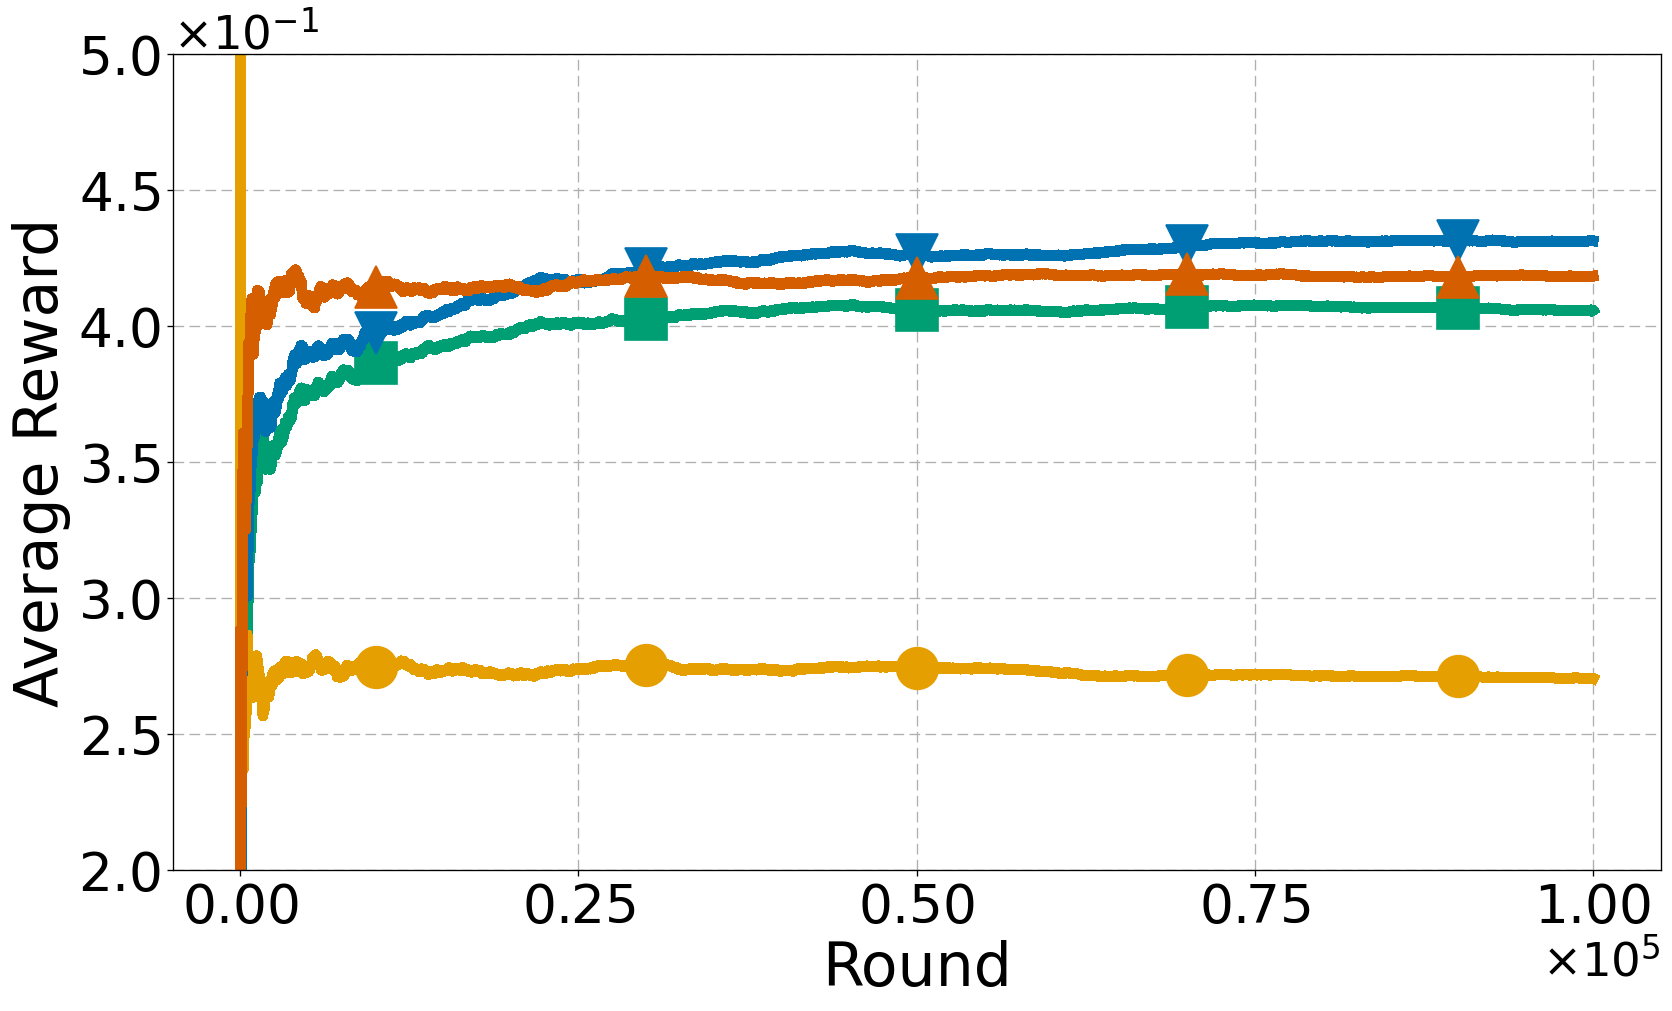

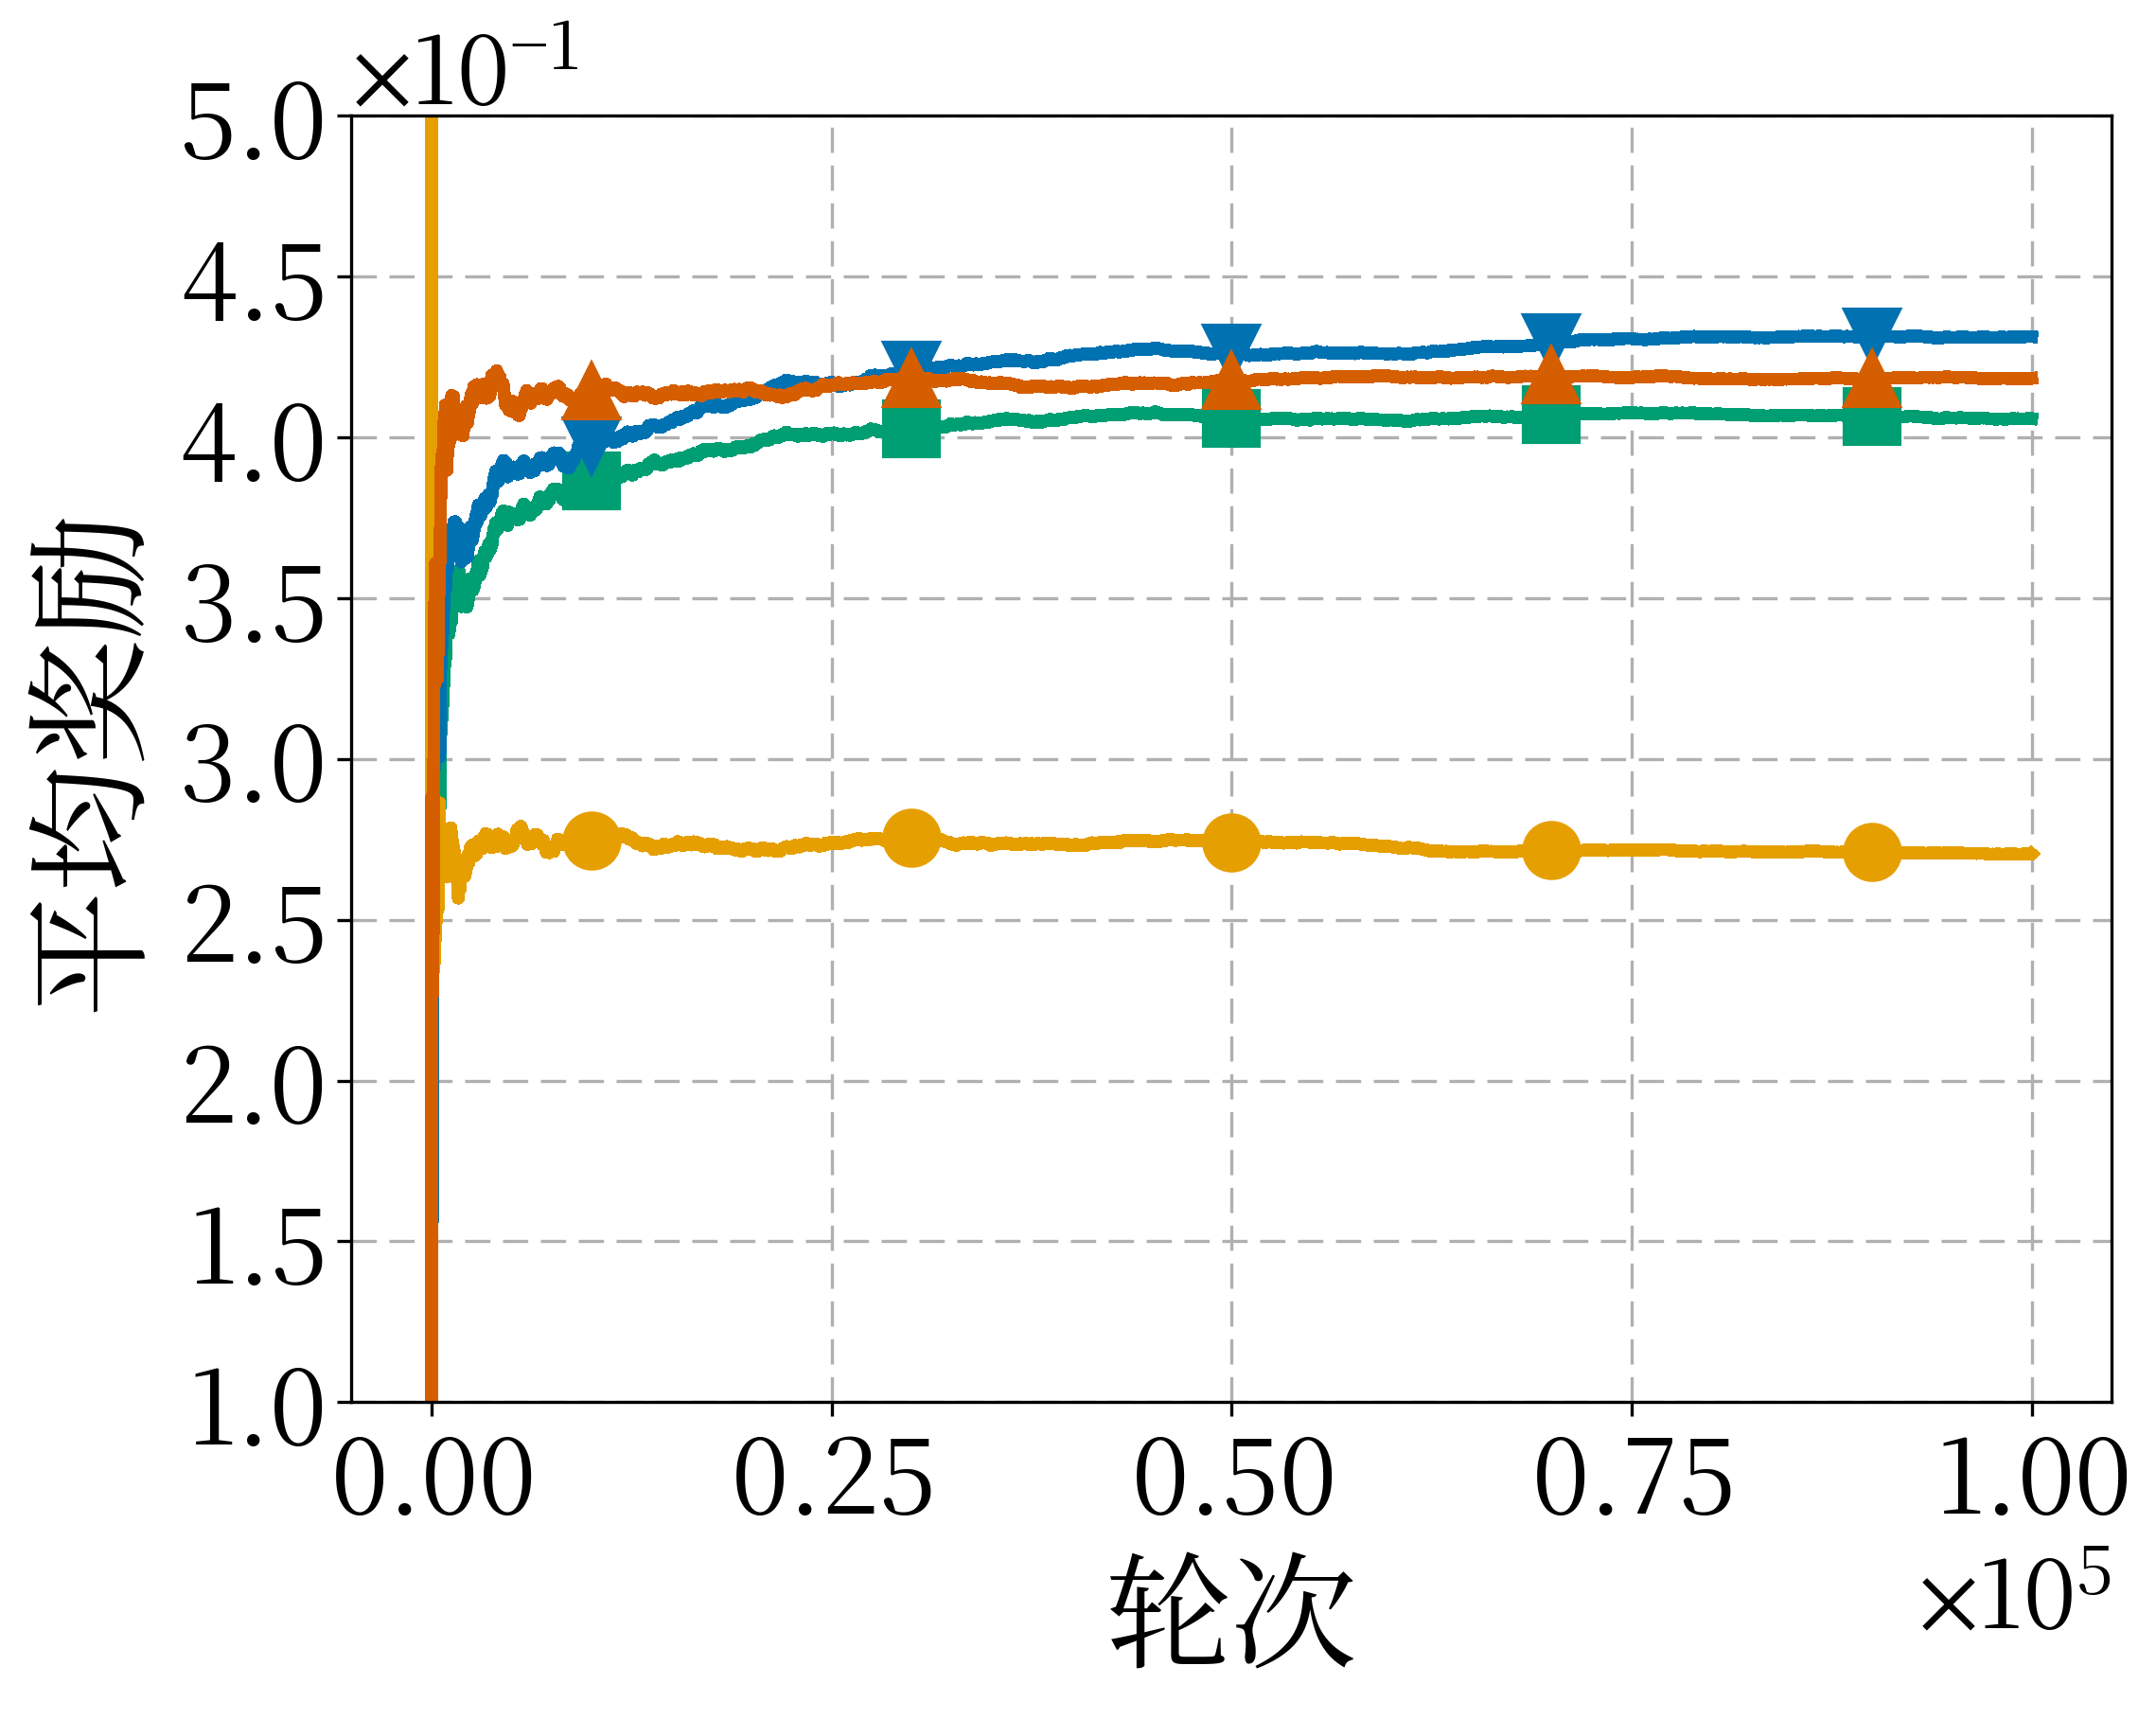

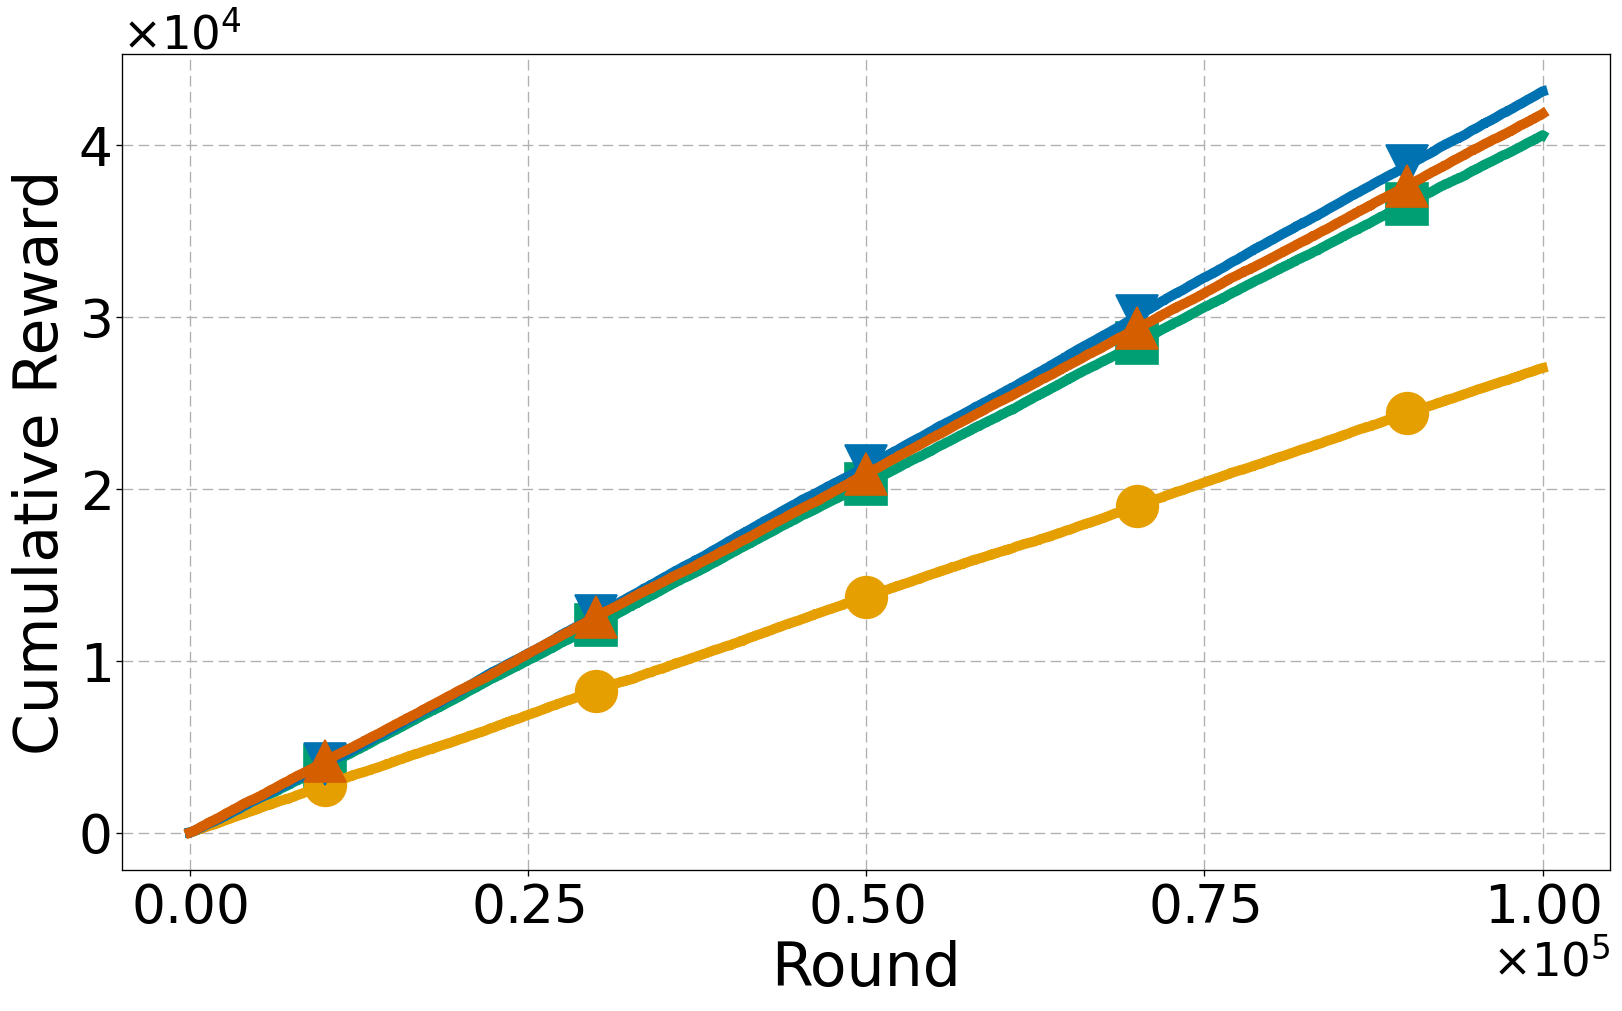

<Figure size 1920x1080 with 0 Axes>

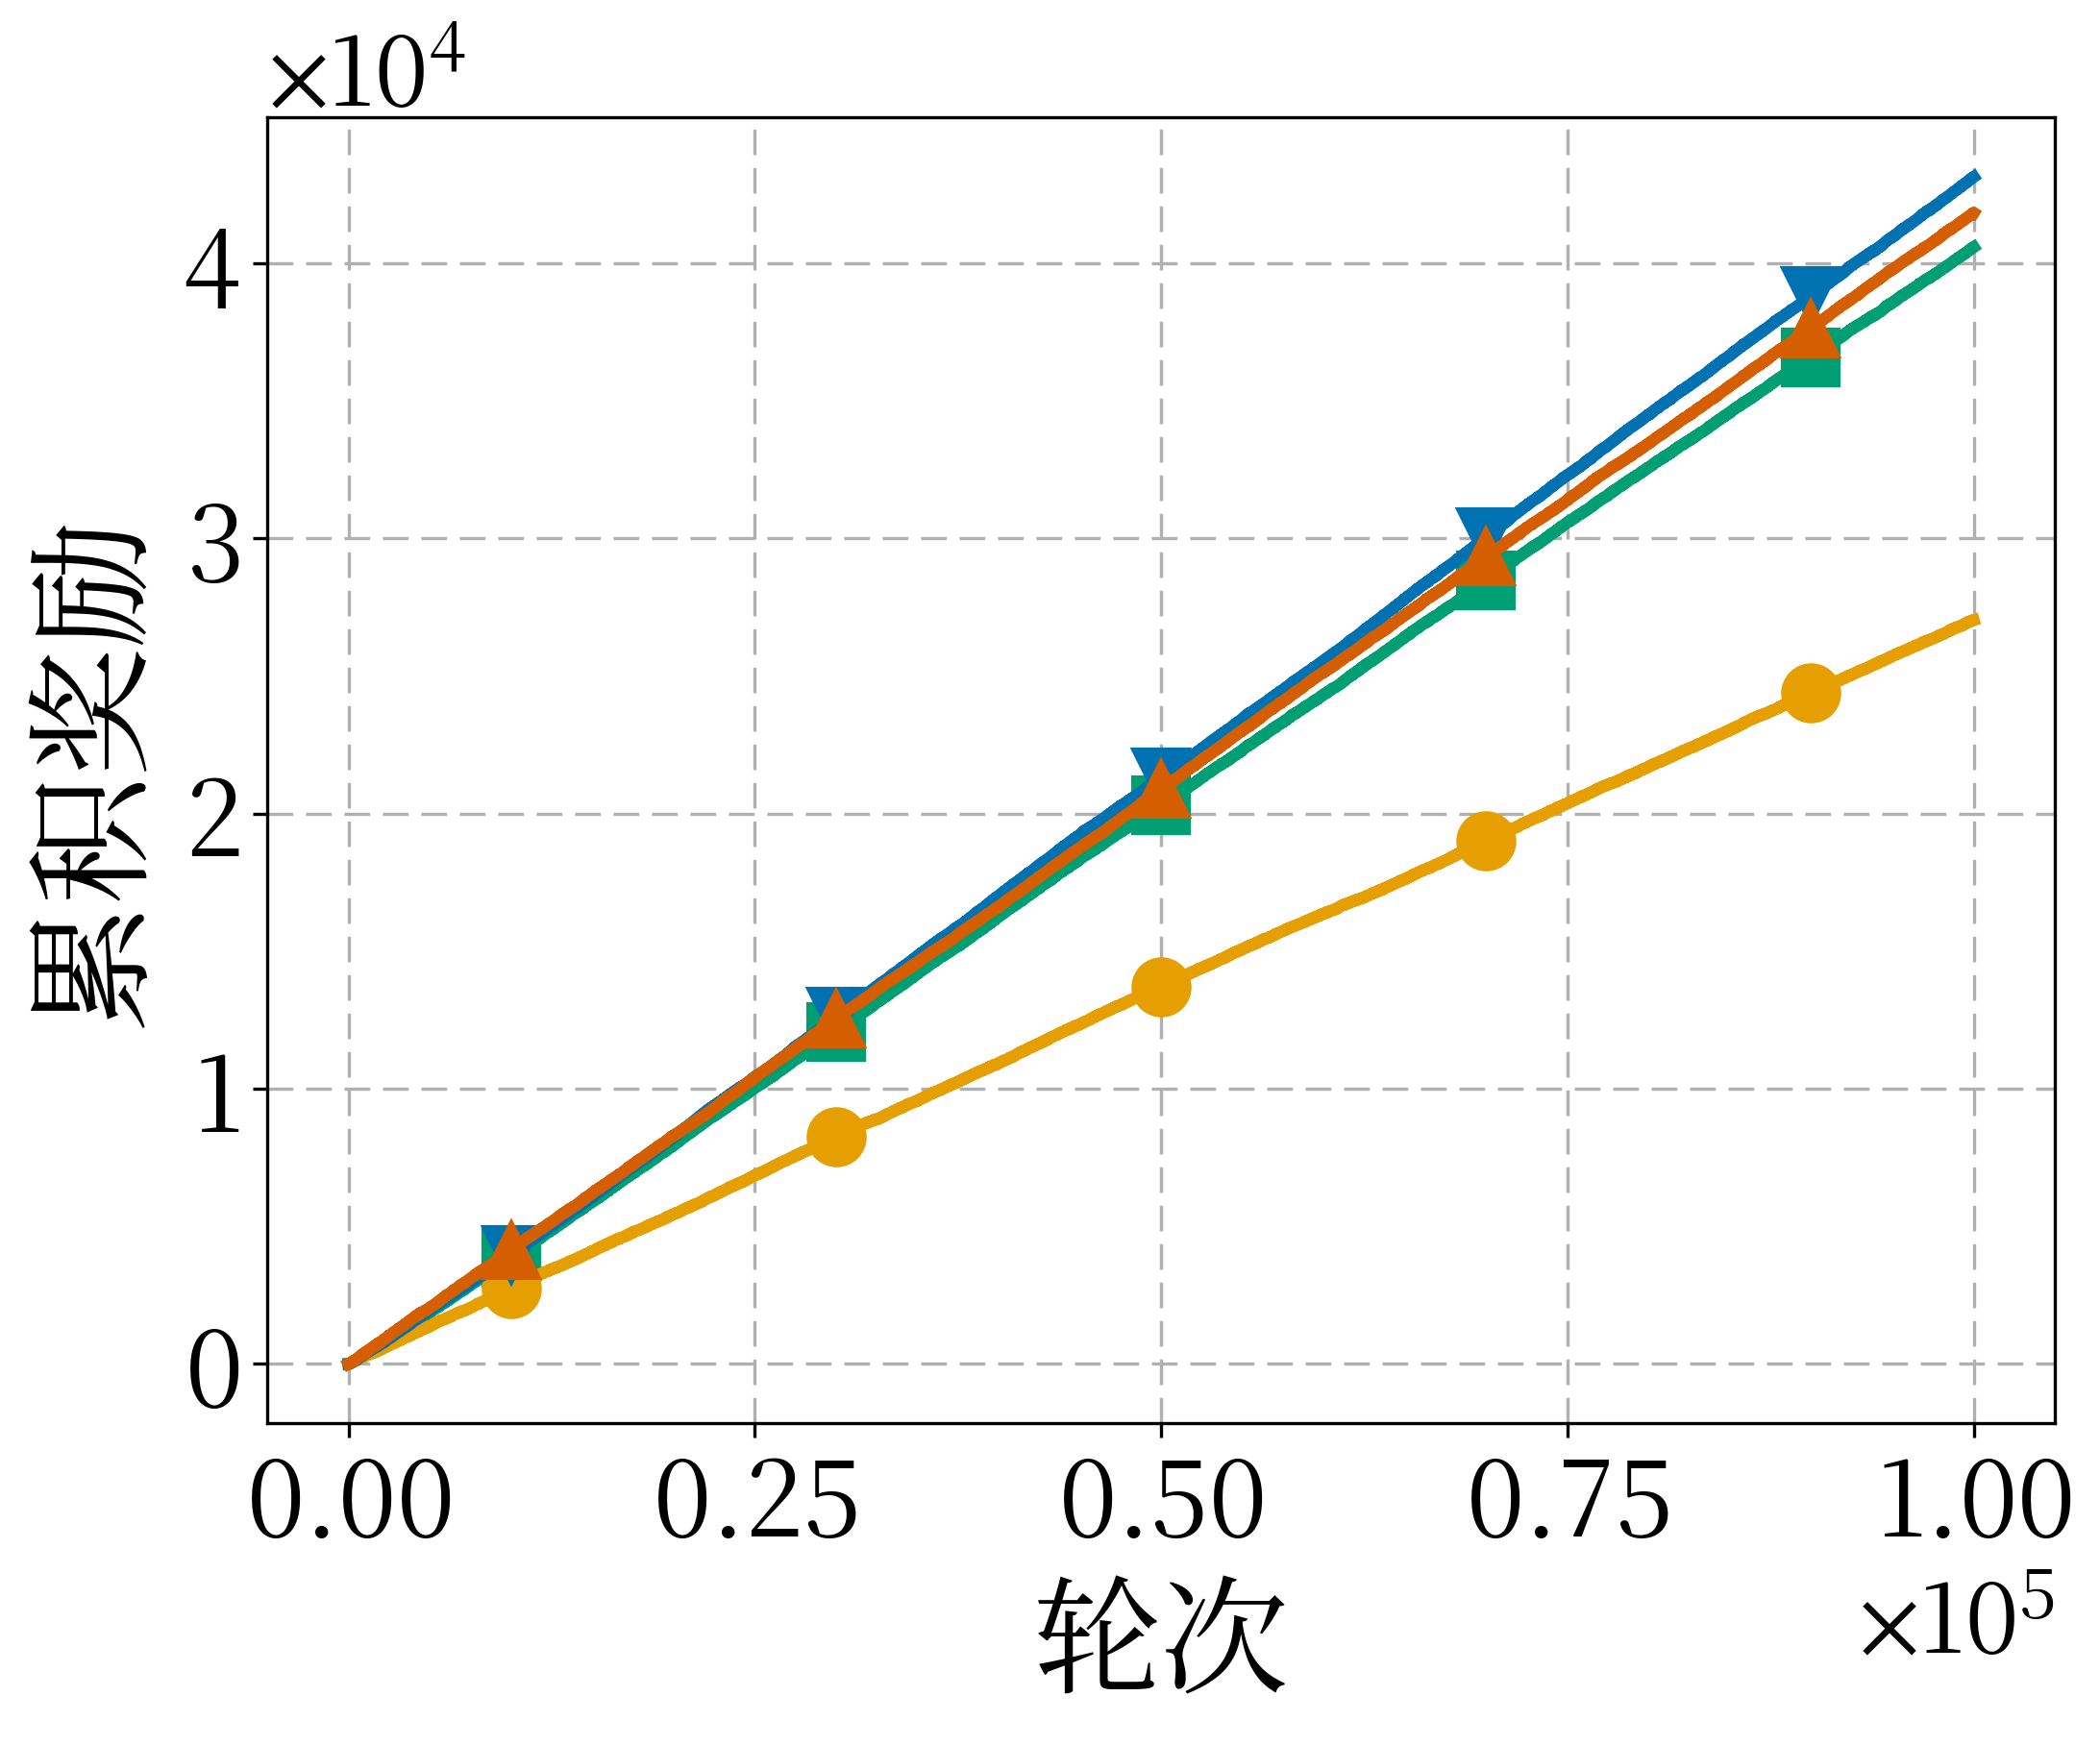

<Figure size 2400x1800 with 0 Axes>

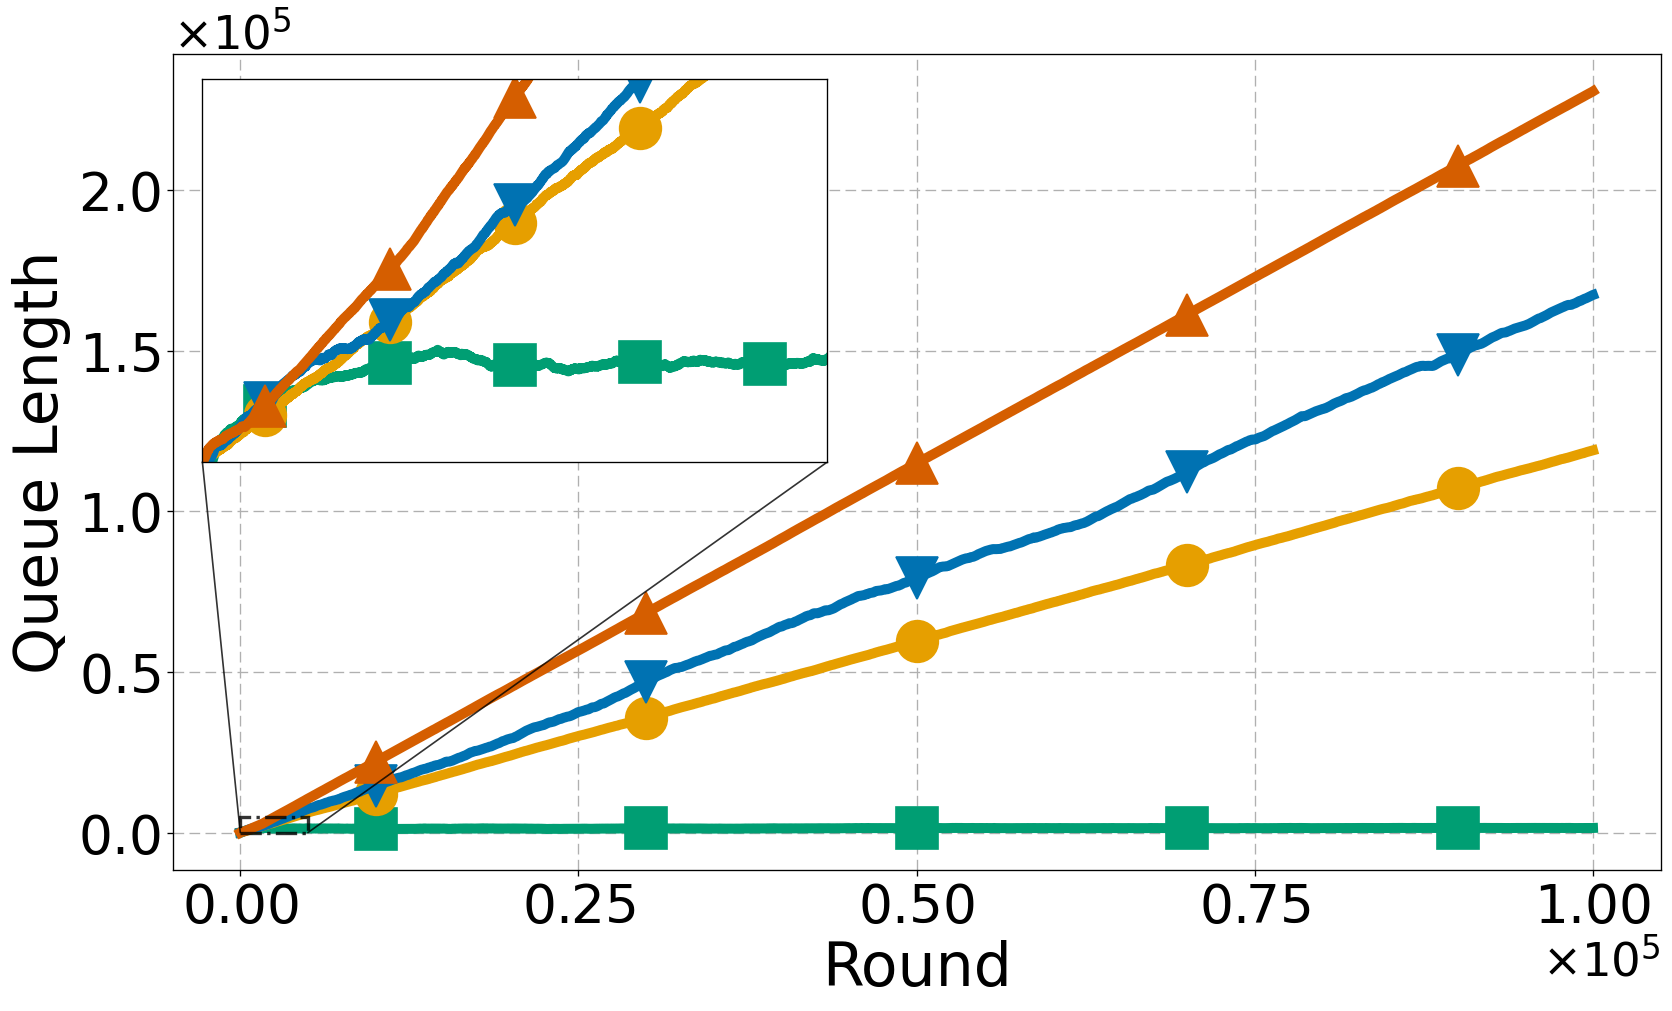

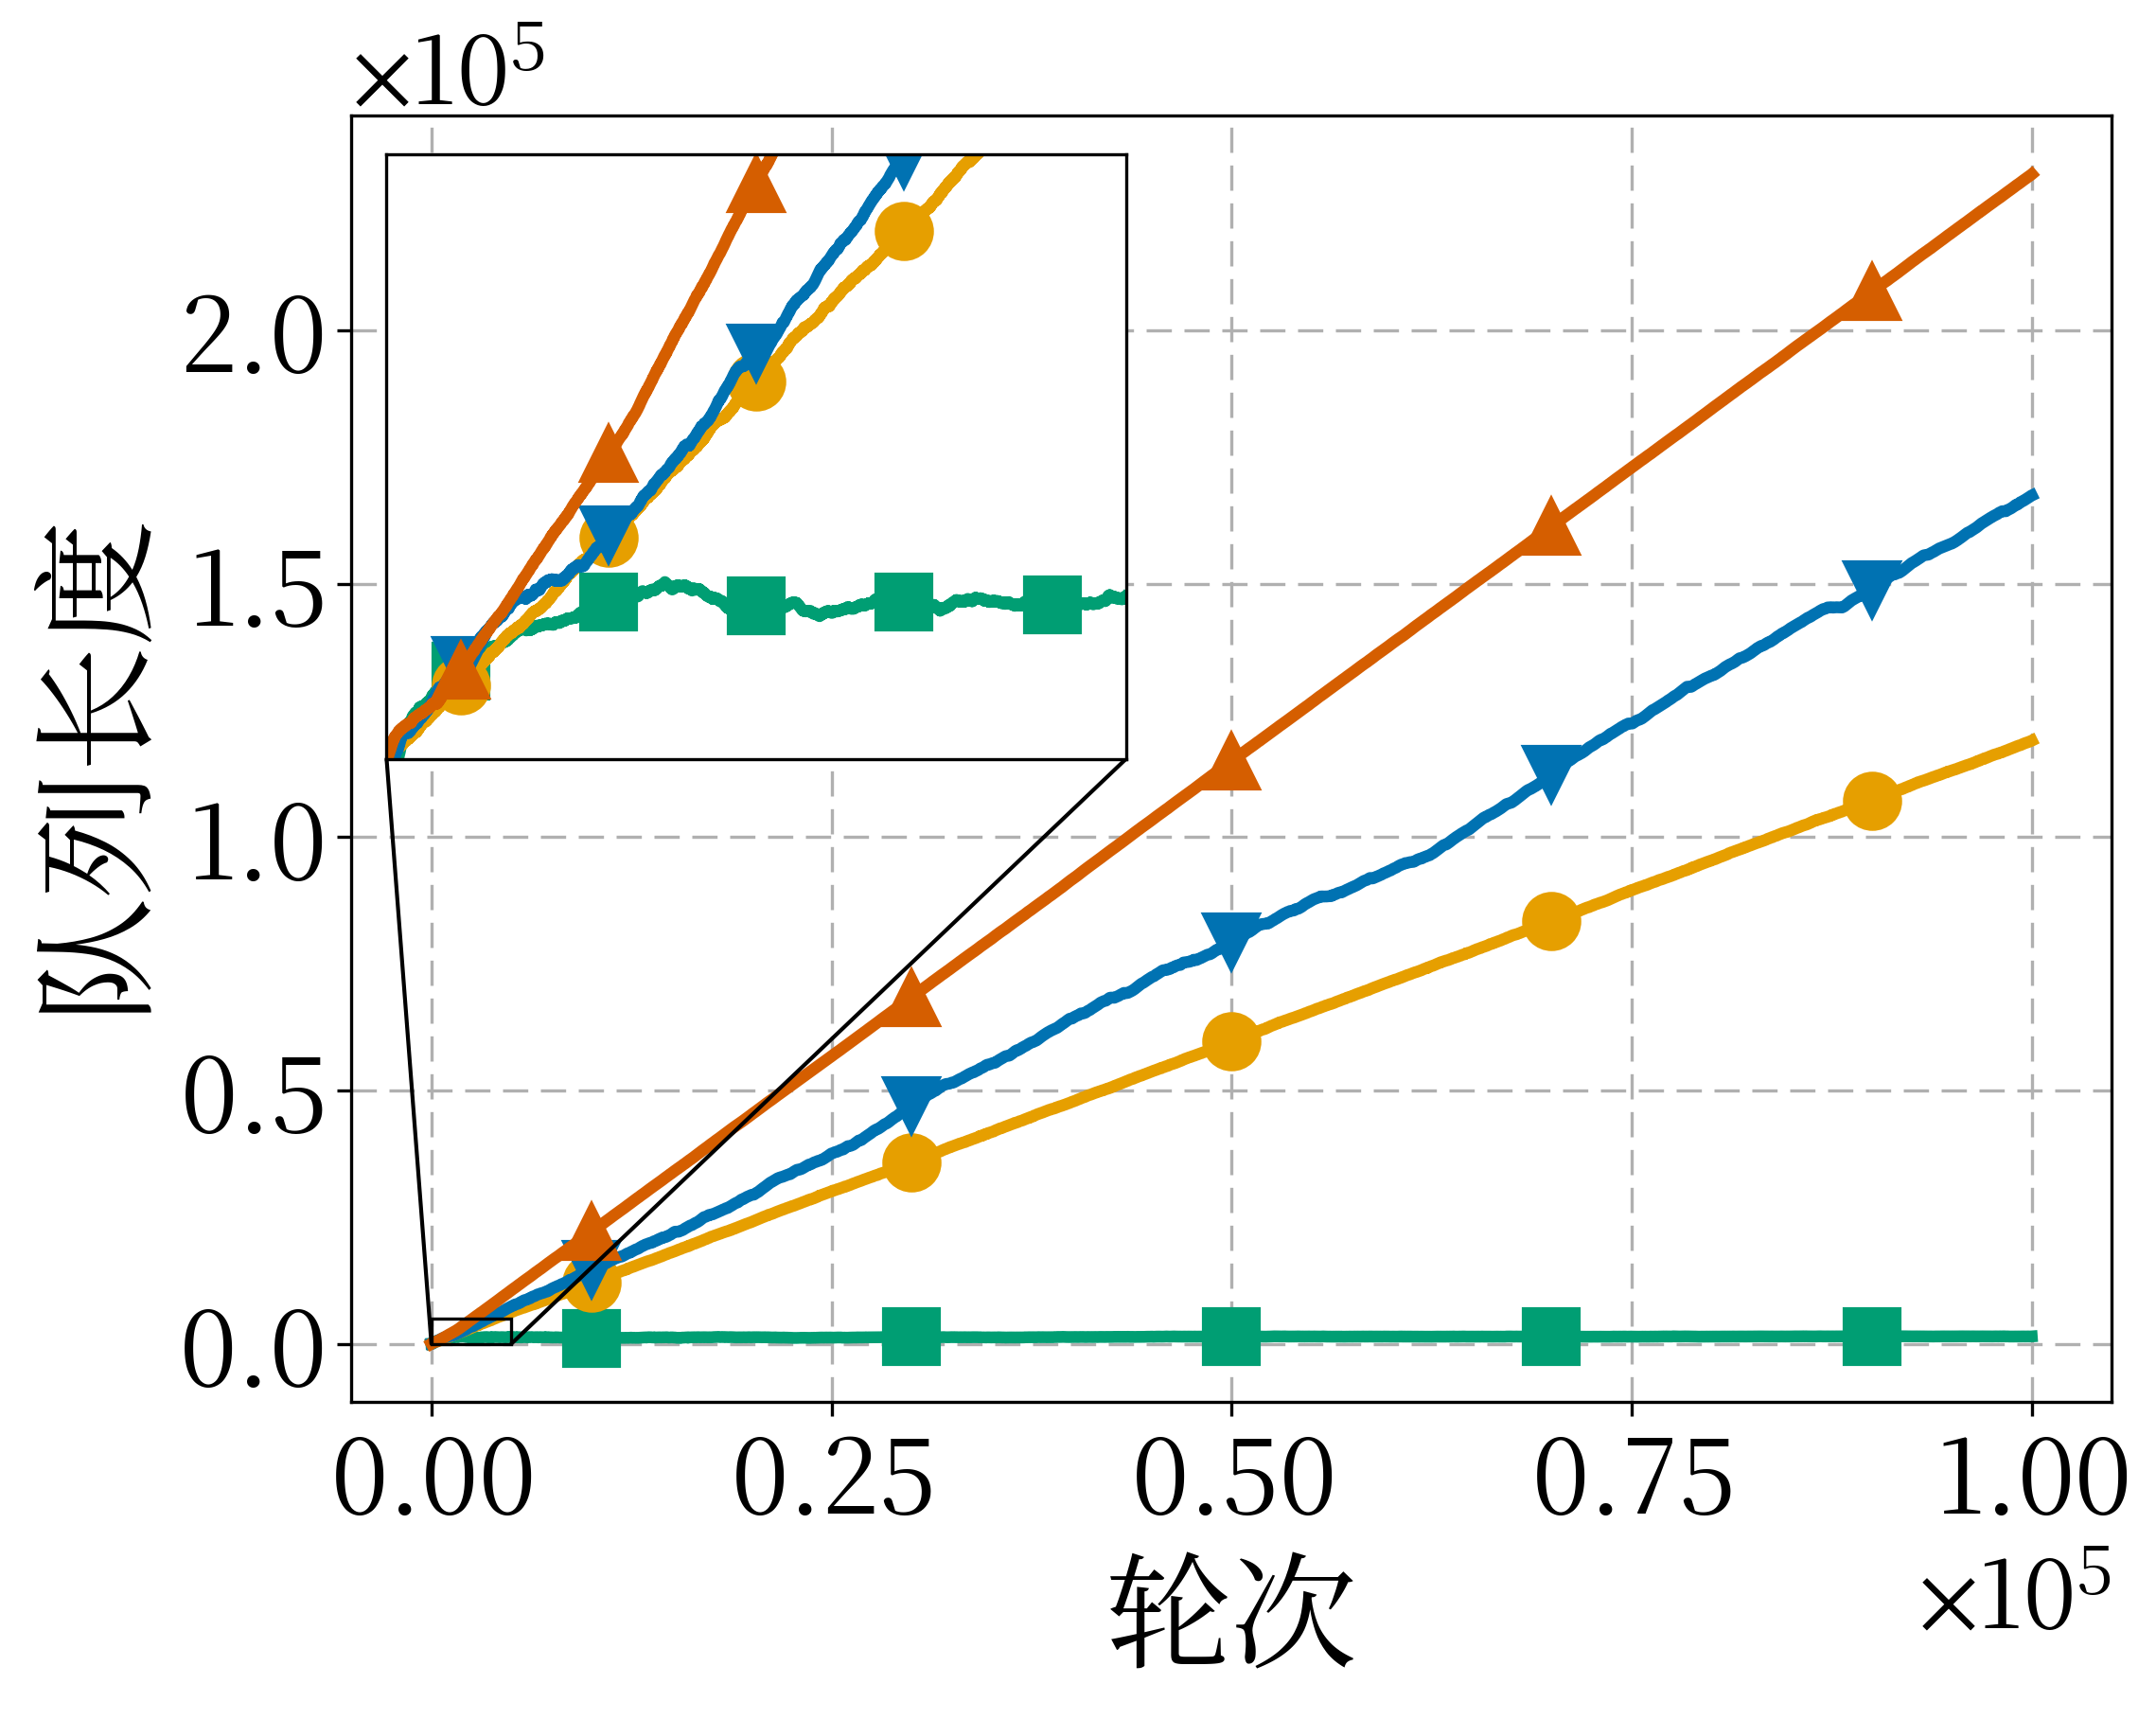

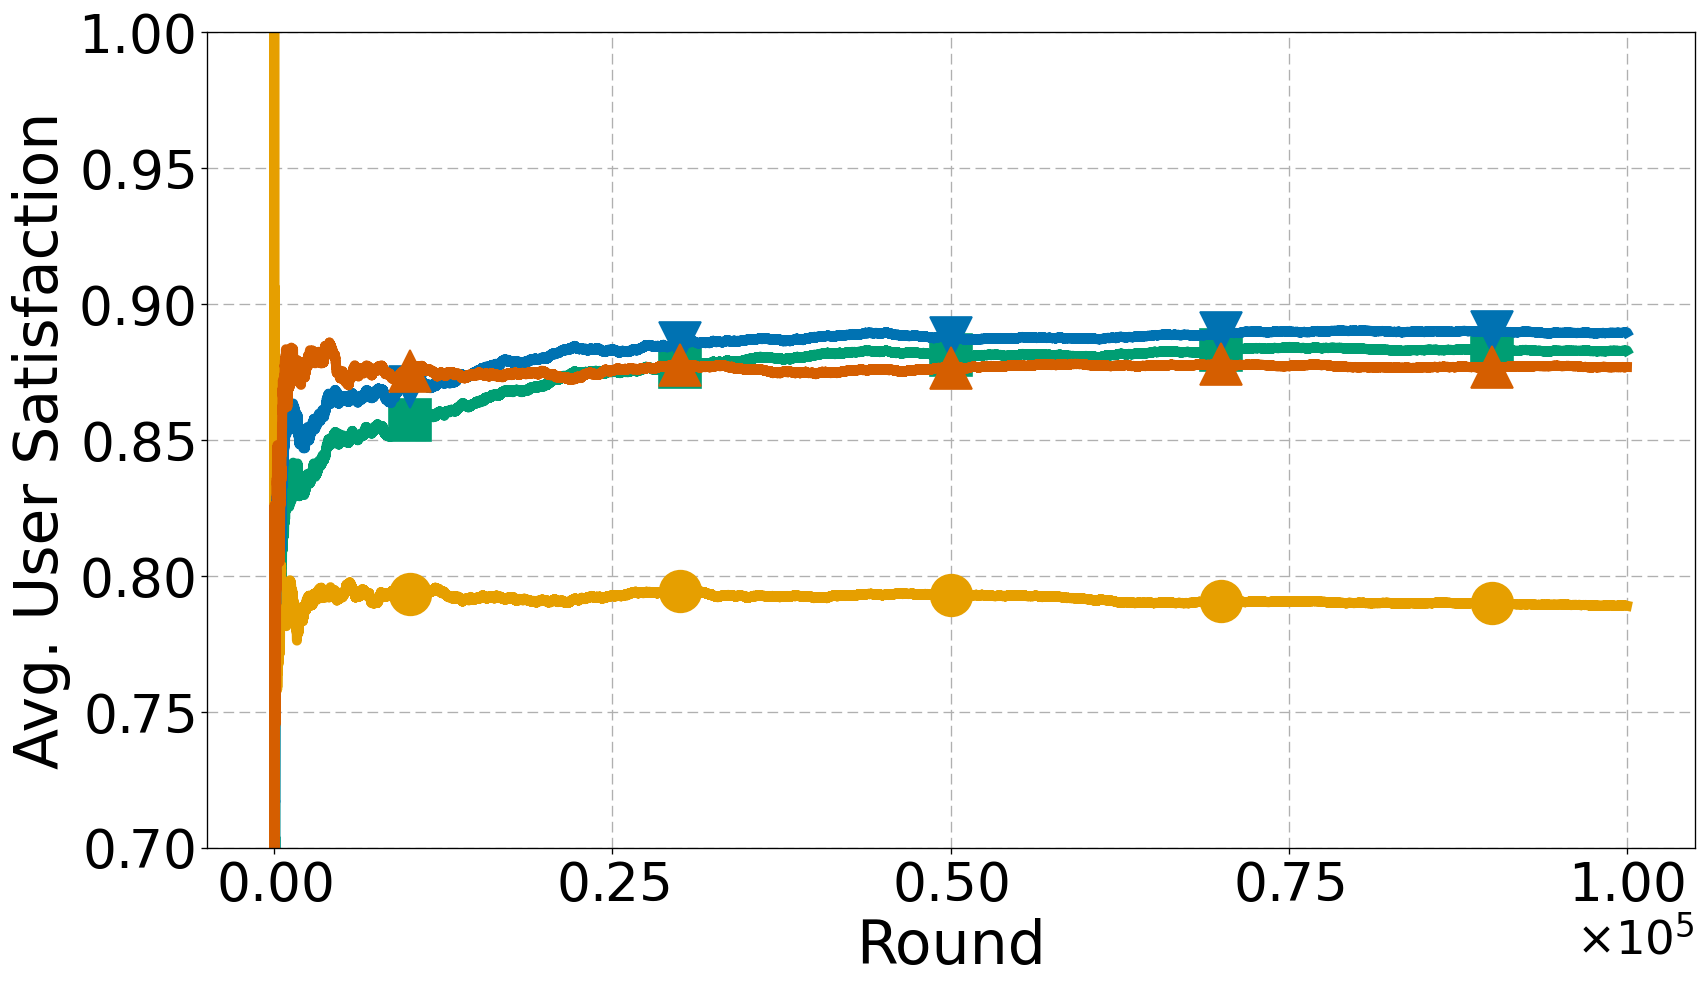

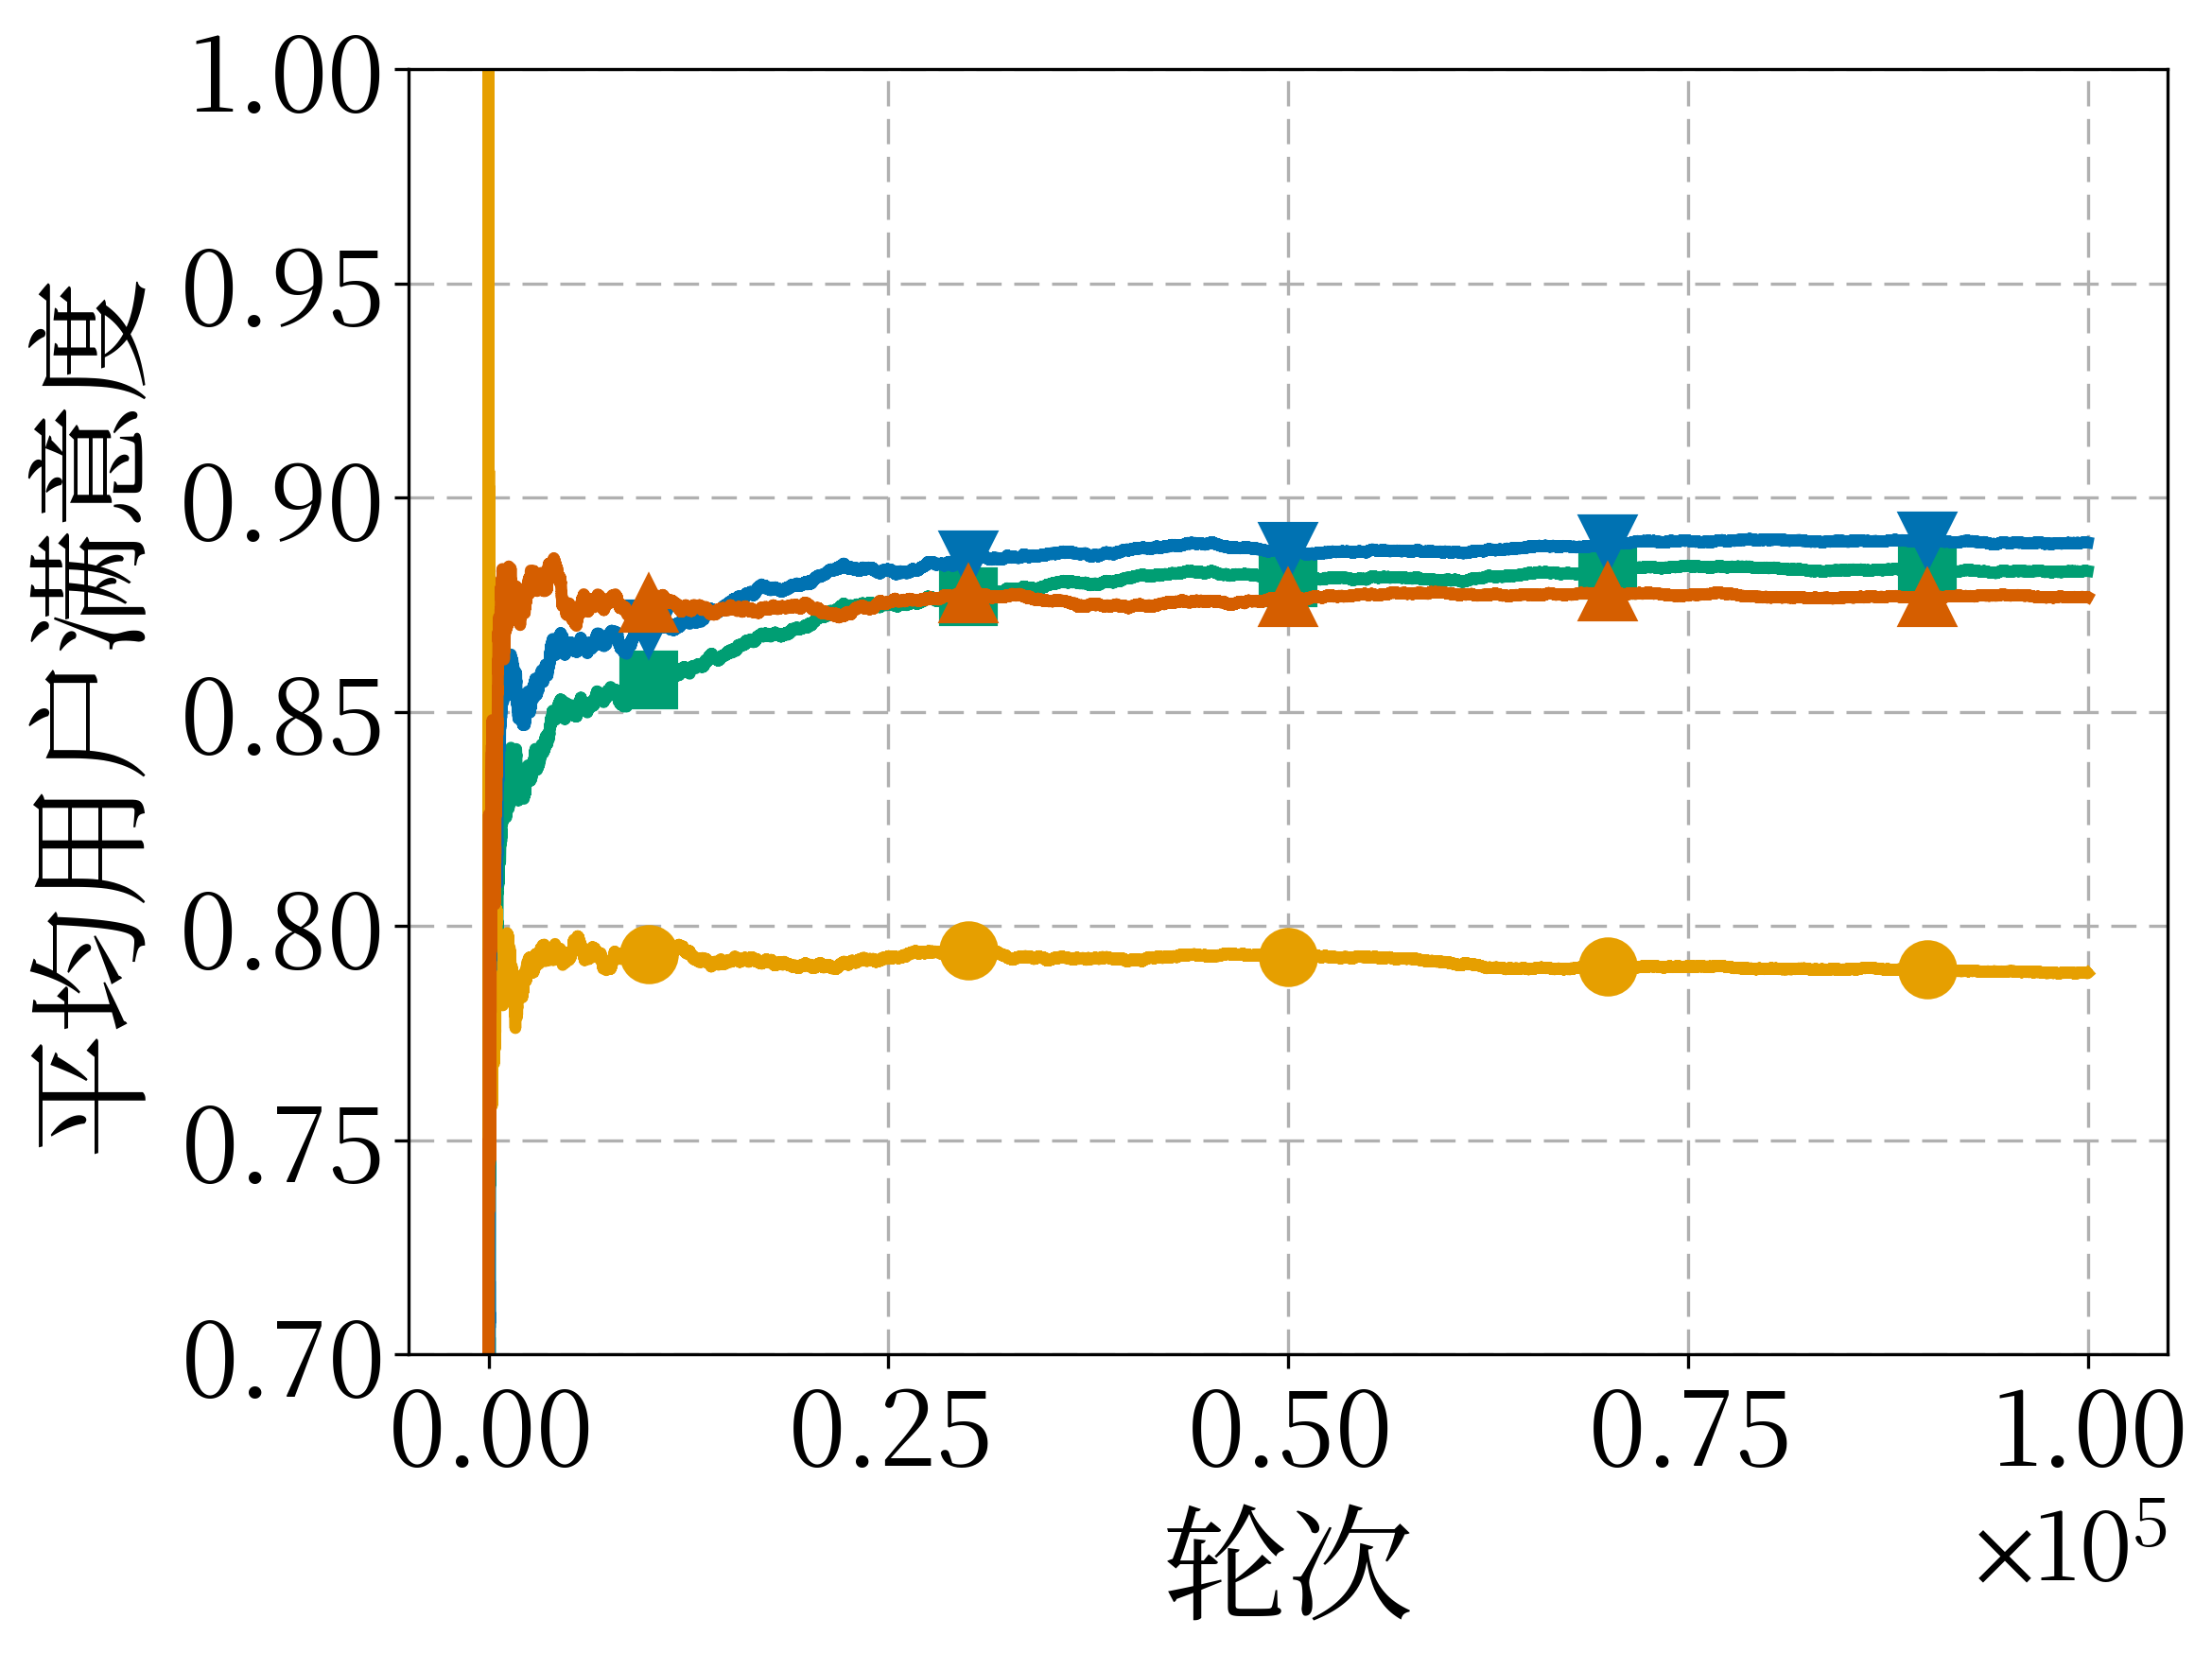

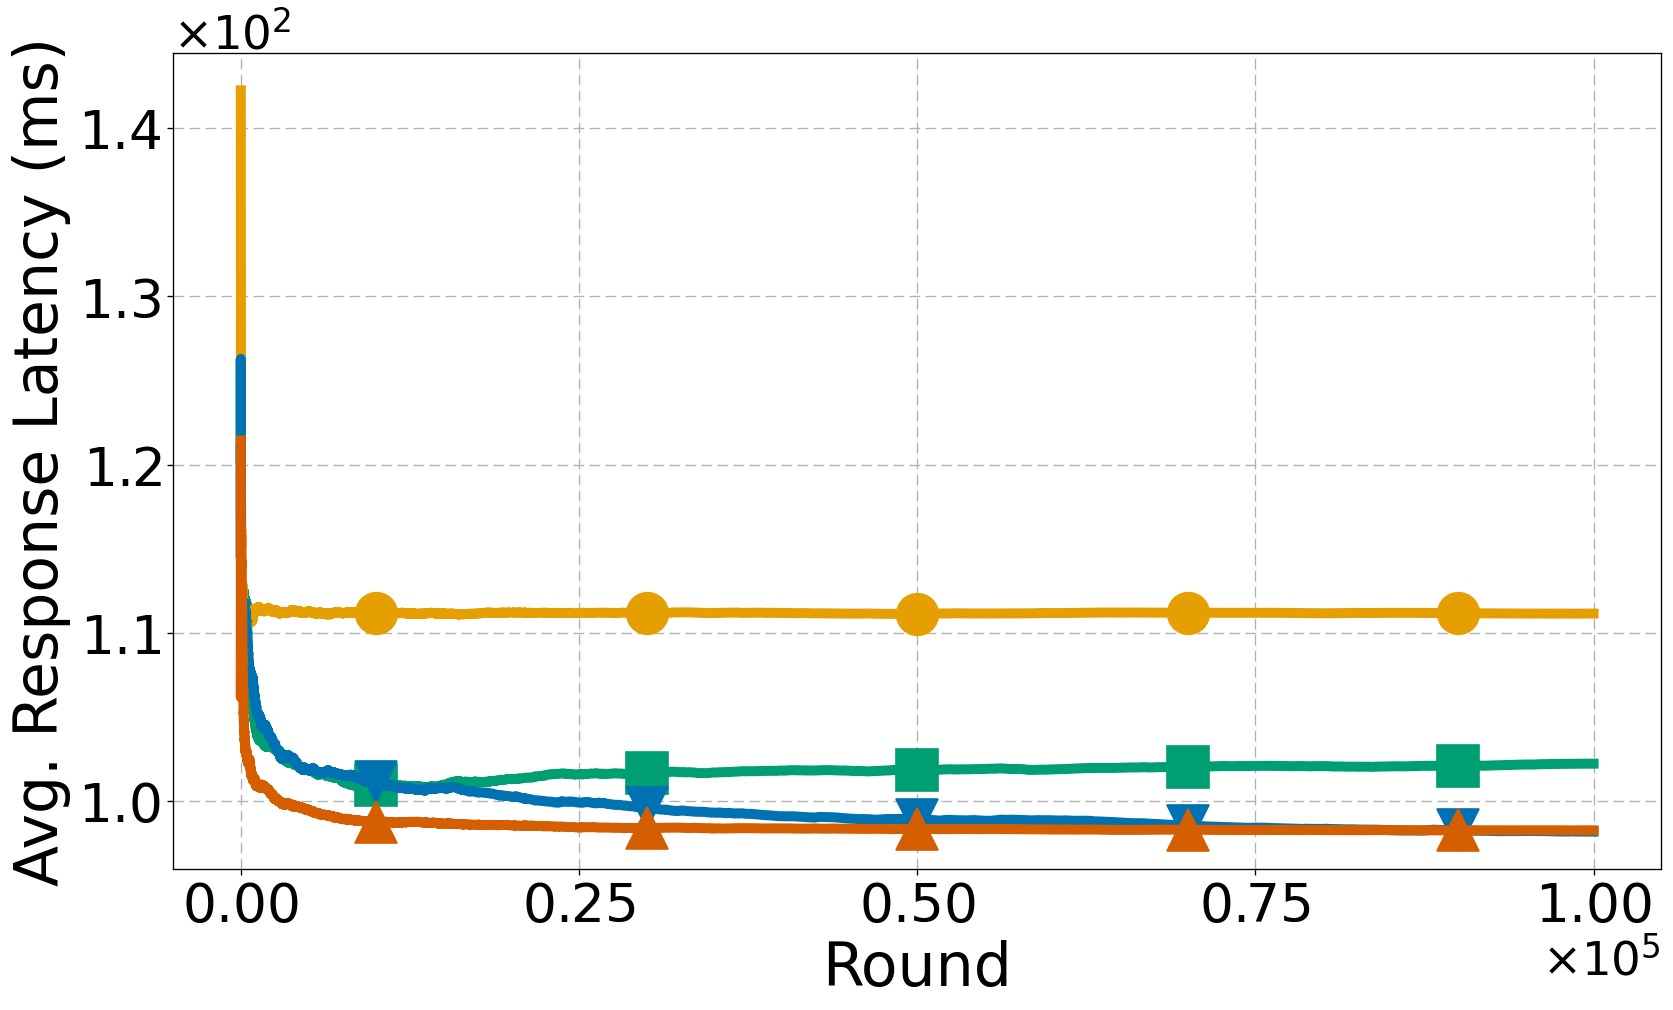

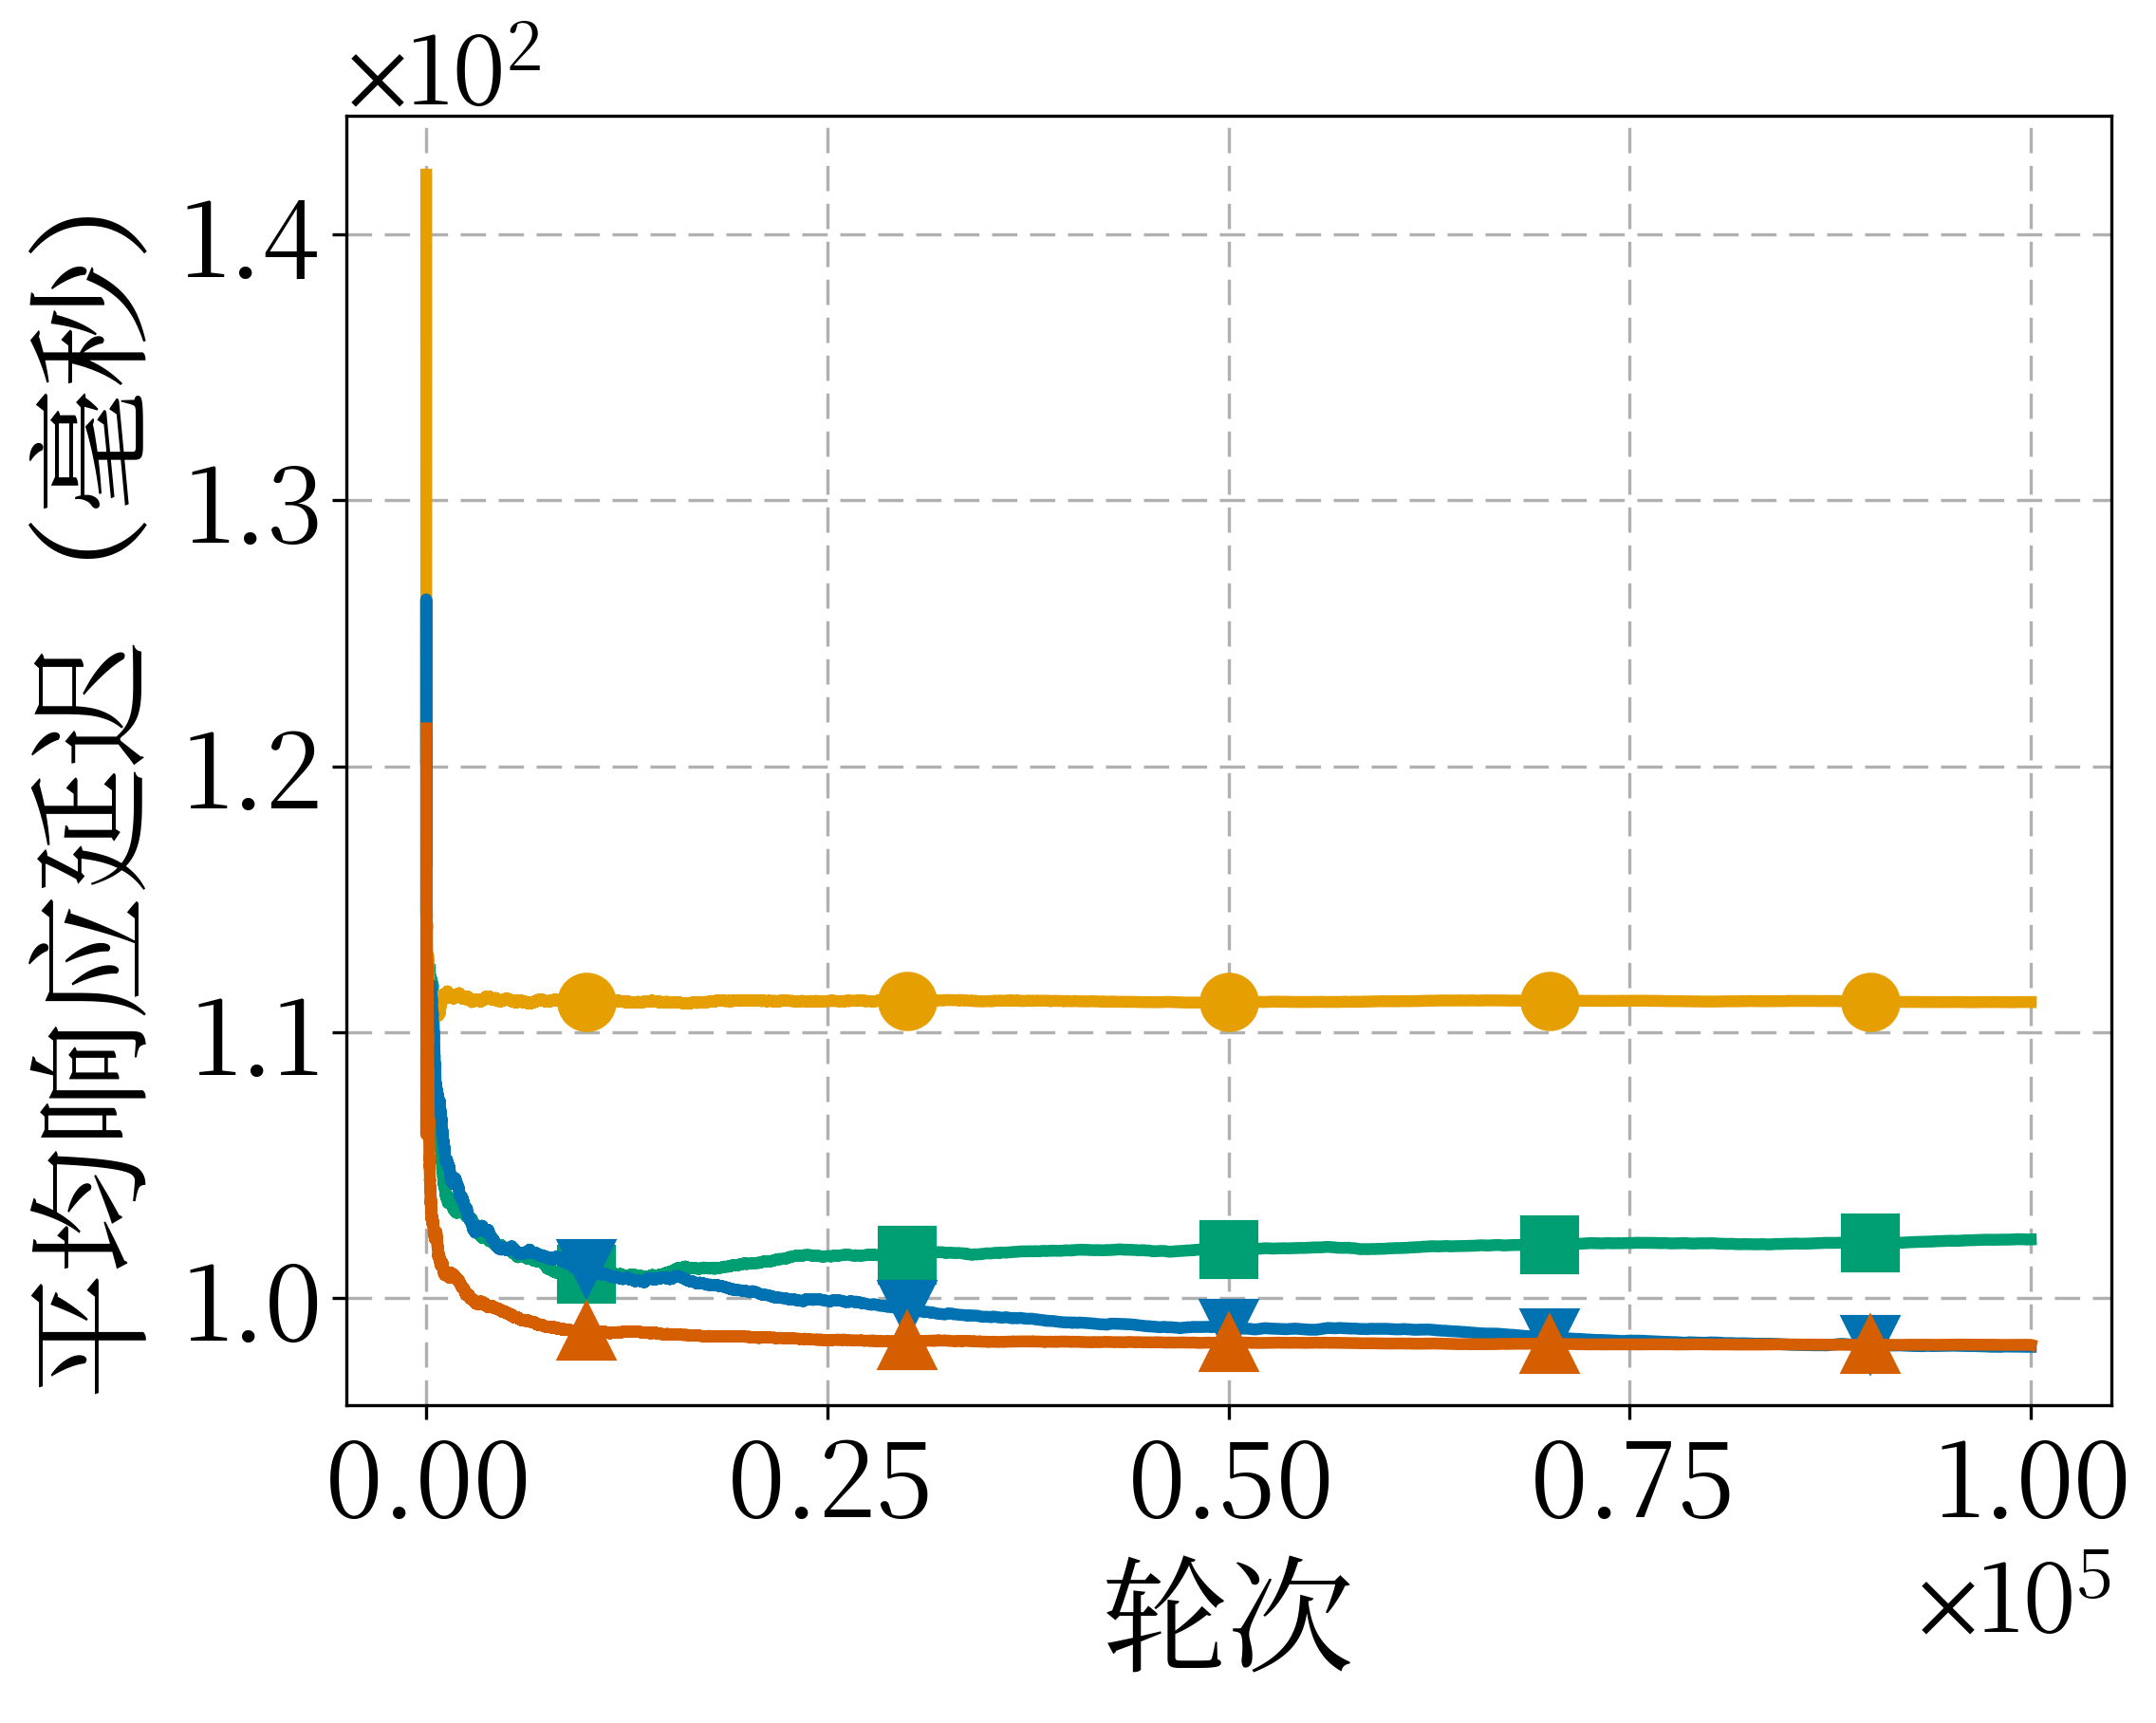

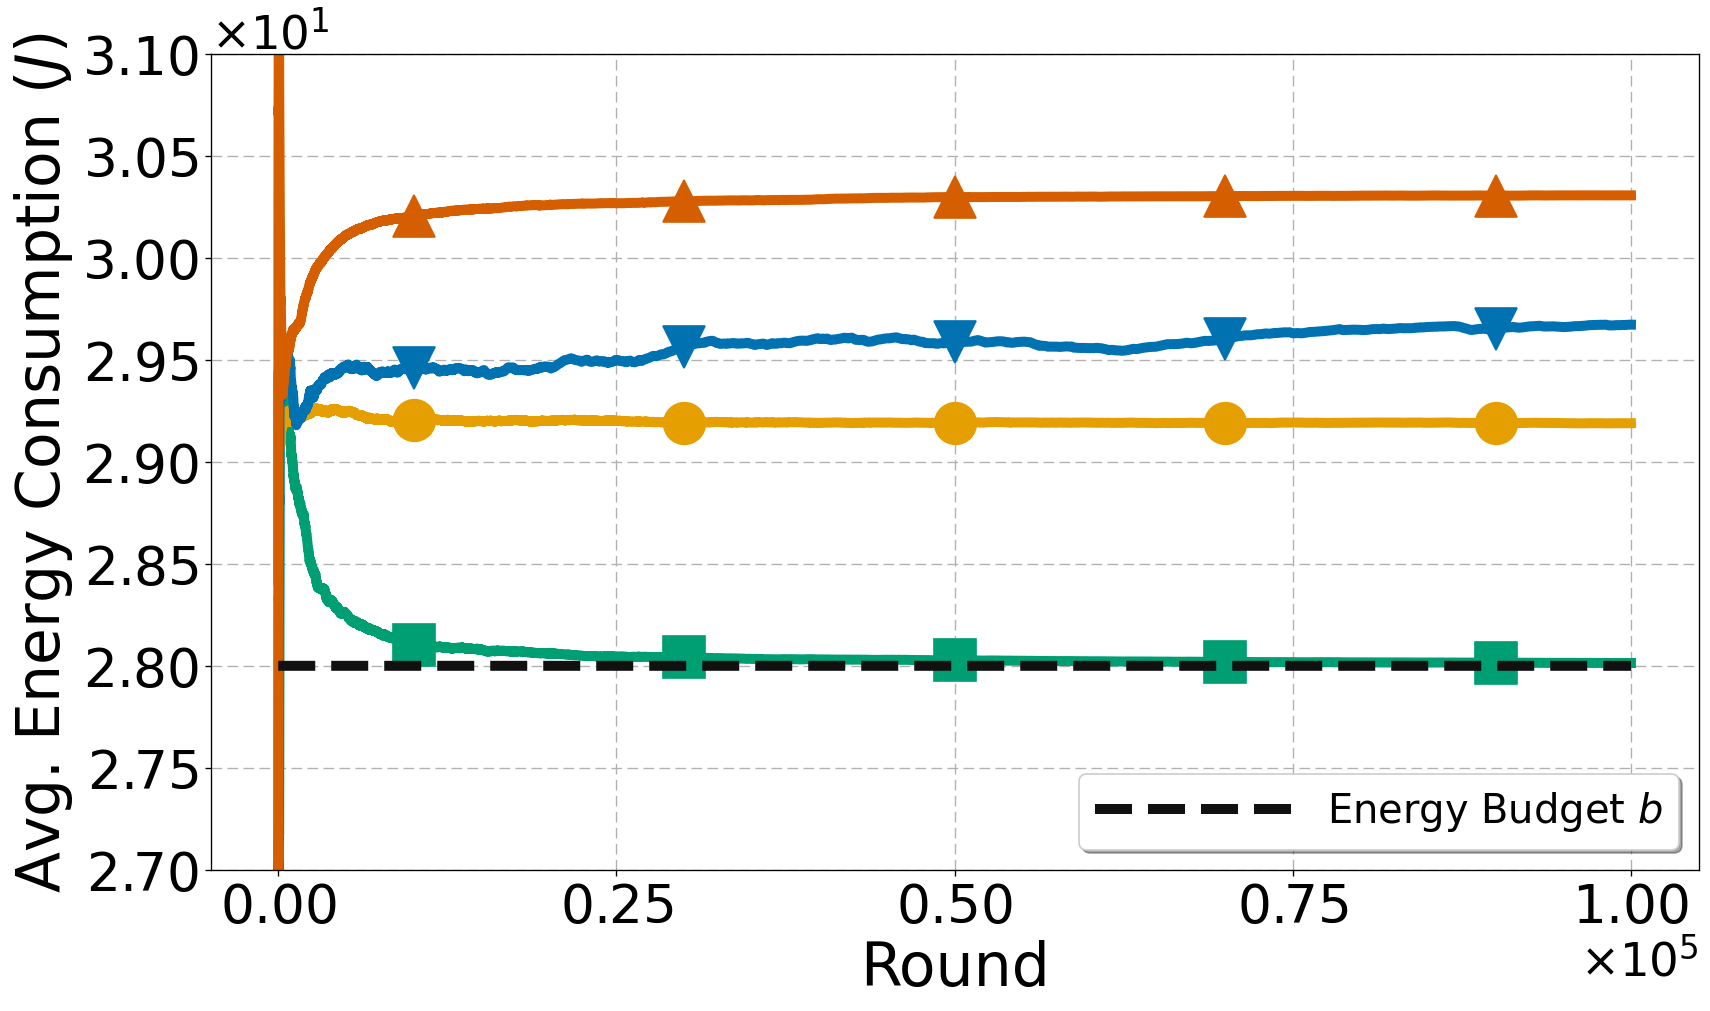

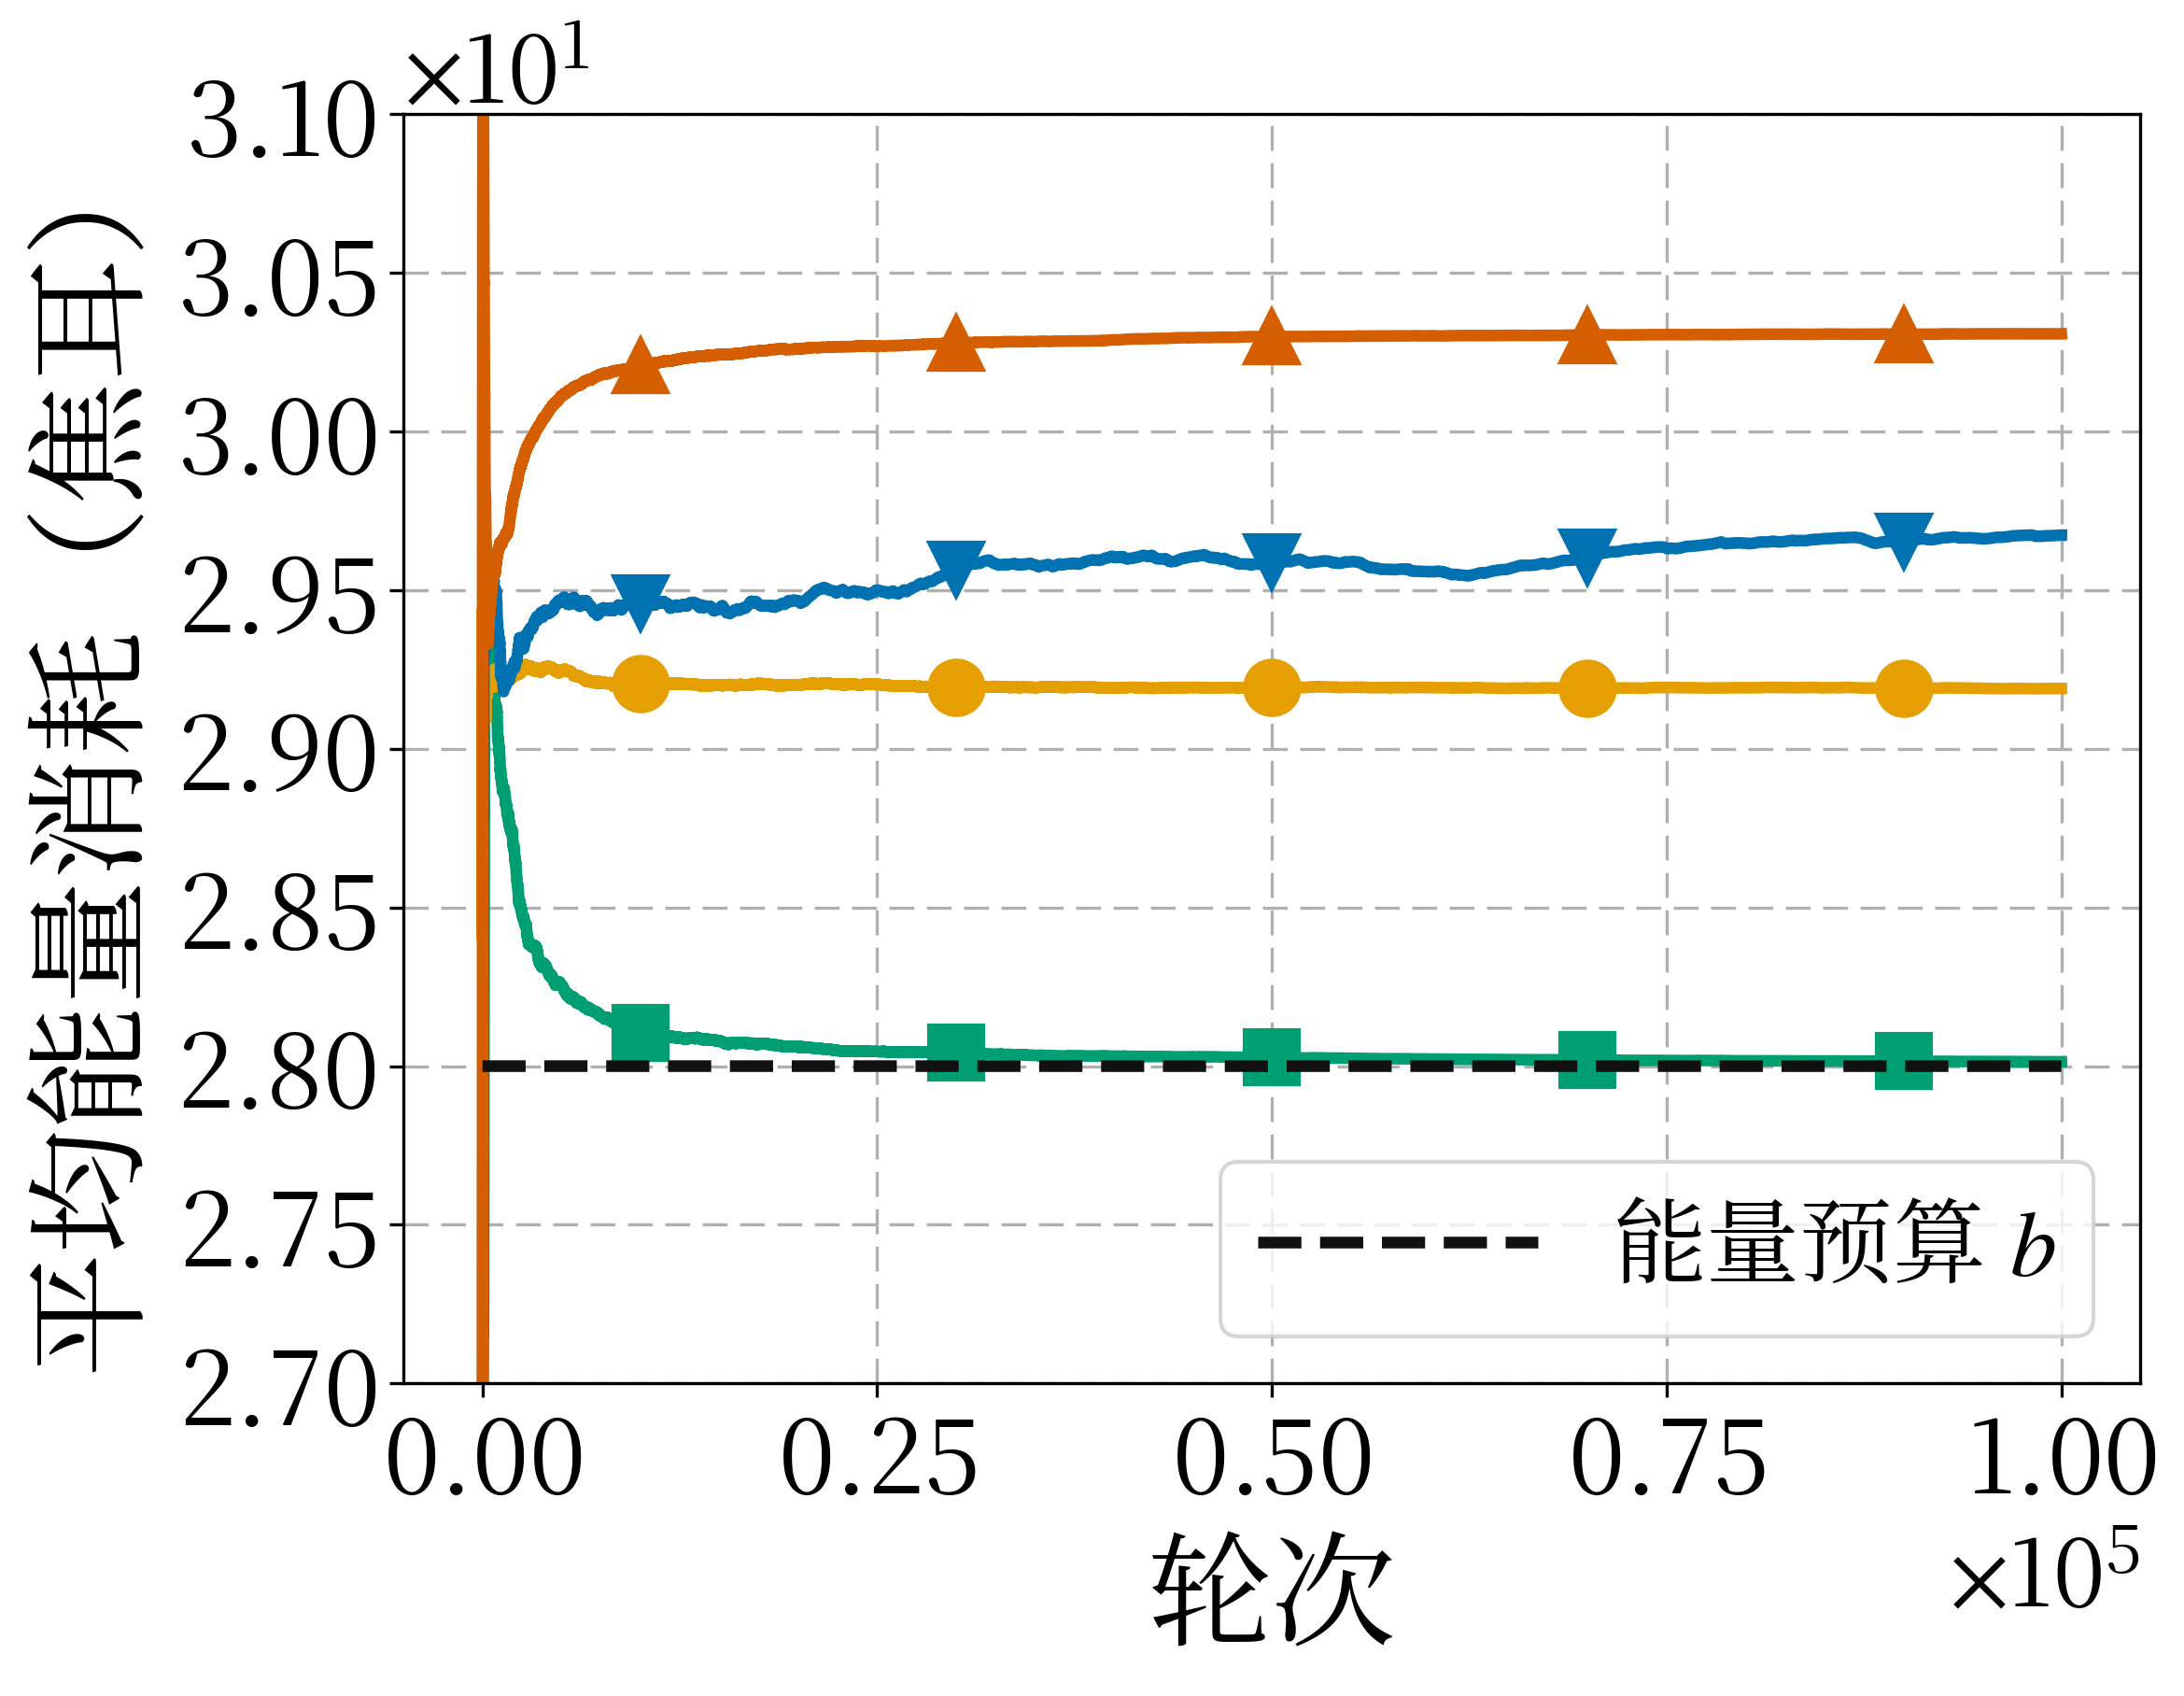

In [4]:
plot()
